Notebook : BERT fine-tuning
------------------------------------
-------------------------------------

## 1.Libraries

In [ ]:
#install libraries
#-------------------------------------------------
!pip install transformers==2.8.0 #for training bert
!pip install --upgrade tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tokenizers-0.5.2-cp37-cp37m-manylinux1_x86_64.whl (5.6 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.12.1
    Uninstalling tokenizers-0.12.1:
      Successfully uninstalled tokenizers-0.12.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tokenizers-0.12.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (6.6 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.5.2
    Uninstalling tokenizers-0.5.2:
      Successfully uninstalled tokenizers-0.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 2.8.0 requires tokenizers==0.5.2, but you have tokenizers 0.12.1 which is incompatible.


In [ ]:
#import libraries
#-------------------------------------------------
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.utils import shuffle #shuffle pandas dataframe

#---- download/unzip datas
import os
import zipfile
import tarfile

#----- data cleaning
import re #to find integers & floats in a string 
import string #for text cleaning
from string import digits
#import unidecode
#from spellchecker import SpellChecker #spell checker

#----- machine learning splitting datasets
from sklearn.model_selection import train_test_split #split train/test data

#----- for BERT fine-tuning
#import tensorflow as tf

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler #DataLoader
import torch.nn as nn
import torch.nn.functional as F

from transformers import BertTokenizer, BertModel, BertConfig
from transformers import AdamW, get_linear_schedule_with_warmup

import random
import time

#---- Do not display warnings of tokenization
import logging 
logging.getLogger('transformers.tokenization_utils').disabled = True

#----- evaluate the performance of the model
from sklearn.metrics import accuracy_score, f1_score
#---- load an already fine-tuned model for resume training
import shutil
#----- write in xlsx file
import openpyxl
from openpyxl import load_workbook

%matplotlib inline

### List of global variables

List of global variables used in this notebook, defined progressively throughout the notebook


Variables for saving information: 
- MY_FOLDER_______________________2.1
- PATH______________________________2.1
- NAMES____________________________2.2
- URLS______________________________2.2
- DFs_______________________________2.2
- MIX_______________________________2.4

Variables to train the model:
- NOW_______________________________2.5
- MAX_LEN__________________________4.2
- BERT_MODEL_NAME_______________4.1
- BATCH_SIZE_______________________4.3 
- NUM_LABELS______________________4.4.a
- EPS________________________________4.4.c
- LR__________________________________4.4.c
- NUM_EPOCHS______________________4.5.a

Variables to retrieve saved information: 
- RESUME 
- CKP_NAME
- FULL_RUN

### Main documentation

For this notebook, I adapted the code found here:

https://skimai.com/fine-tuning-bert-for-sentiment-analysis/ 

http://mccormickml.com/2019/07/22/BERT-fine-tuning/#2-loading-cola-dataset 

https://towardsdatascience.com/how-to-apply-transformers-to-any-length-of-text-a5601410af7f

if the last link doesn't work try: 
- https://arxiv.org/abs/1908.10063
- https://github.com/jamescalam/transformers/blob/main/course/language_classification/03_long_text_sentiment.ipynb
- https://github.com/jamescalam/transformers/blob/main/course/language_classification/04_window_method_in_pytorch.ipynb
- https://www.udemy.com/course/nlp-with-transformers/?couponCode=JUN2022

https://towardsdatascience.com/building-a-multi-label-text-classifier-using-bert-and-tensorflow-f188e0ecdc5d

https://medium.com/analytics-vidhya/multi-label-text-classification-using-transformers-bert-93460838e62b

https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=i0yQnuSFsjDp

## 2.Datasets


### 2.1. Working directory 

> To access the datasets for the first time: 

Go to the **Shared Drive** > **Dashborad project**  and find the folder **Notebook_dashboard_project**. 

Right click on the folder **Notebook_dashboard_project** > **Add Shorcut** and add the shorcut in **My Drive**. You can choose to put the shorcut in **My Drive** directly or in the folder of your choice which we will call **MY_FOLDER** 

If you chose a special folder, change the name of the variable `MY_FOLDER` in the cell below to match the name of your folder as follows: `/my_folder_name`. 

Run the cell below and allow access to your drive.

In [ ]:
MY_FOLDER = "" 

#---- to upload datasets from your drive
from google.colab import drive
drive.mount('/content/drive')
#---- go to the "1_RawDatasets" folder
PATH = '/content/drive/My Drive/' + "Notebook_dashboard_project" +  MY_FOLDER 
dataset_path = PATH + "/1_RawDatasets"
os.chdir(dataset_path)
#---- list all elements in the "datasets" folder
print('\ndataset_path:', dataset_path)
print('\nElements in the folder "1_RawDatasets":')
print('------------------------------------------')
!ls 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

dataset_path: /content/drive/My Drive/Notebook_dashboard_project/1_RawDatasets

Elements in the folder "1_RawDatasets":
------------------------------------------
'all_kindle_review .csv'
'Amazon Kindle Book Review for Sentiment Analysis.zip'
 amazon_review_full_csv
 amazon_review_full_csv.tar.gz
 data.csv
'Financial Sentiment Analysis.zip'
'Generic Sentiment Multidomain Sentiment Dataset.zip'
'IMDB dataset Sentiment analysis.zip'
 Laptop_Train_v2.csv
 Reddit_Data.csv
'SemEval 2014 Task 4 AspectBasedSentimentAnalysis.zip'
 Train.csv
'Twitter and Reddit Sentimental analysis Dataset.zip'


### 2.2. Download datasets

Find below a list of possible datasets to use to fine-tune our model.\
We aim to produce as general a dataset as possible

<font color = "red">__Dataset 1:__  </font> <font color = "blue"> Amazon Kindle Book Review for Sentiment Analysis </font>\
Can find dataset here: https://www.kaggle.com/datasets/meetnagadia/amazon-kindle-book-review-for-sentiment-analysis

__Desciption:__
- <font color = "red"> 5-score </font> dataset of product reviews from Amazon Kindle Store category from May 1996 - July 2014. 
- Contains total of 982619 entries. 
- Each reviewer has at least 5 reviews and each product has at least 5 reviews in this dataset.
- Columns: 
    - asin - ID of the product, like B000FA64PK
    -helpful - helpfulness rating of the review - example: 2/3.
    -overall - rating of the product.
    -reviewText - text of the review (heading).
    -reviewTime - time of the review (raw).
    -reviewerID - ID of the reviewer, like A3SPTOKDG7WBLN
    -reviewerName - name of the reviewer.
    -summary - summary of the review (description).
    -unixReviewTime - unix timestamp.
- No NaN/missing values

<font color = "red">__Dataset 2:__  </font><font color = "blue"> Amazon Review Full Score Dataset </font>\
Can find dataset here: https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M?resourcekey=0-TLwzfR2O-D2aPitmn5o9VQ \
Name of the file to download: <font color = "blue"> amazon_review_full_csv.tar.gz </font>

__Description:__

The Amazon reviews full score dataset consists of reviews from amazon collected over a period of 18 years. 
- the file *train.csv* constains 3,000,000 training samples labelled with a score from 1 to 5.
- the file *test.csv* constains 650,000 training samples labelled with a score from 1 to 5.

In each file, there are 3 columns, corresponding to  <font color = "red"> class index (1 to 5) </font>, review title and review text. 

The reviews are on products such as: 
*Books, Electronics, Movies and TV, CDs and Vinyl, Clothing, Shoes and Jewelry, Home and Kitchen, Kindle Store, 
Sports and Outdoors, Cell Phones and Accessories, Health and Personal Care, Toys and Games, Video Games, Tools and Home Improvement, Beauty, Apps for Android, Office Products, Pet Supplies, Automotive, Grocery and Gourmet Food, Baby, Musical Instruments and Instrument, 
Amazon Instant Video*.

<font color = "red">__Dataset 3:__  </font><font color = "blue"> SemEval 2014 Task 4 AspectBasedSentimentAnalysis </font>\
Can find dataset here: https://www.kaggle.com/datasets/charitarth/semeval-2014-task-4-aspectbasedsentimentanalysis

__Description:__ \
Two domain-specific datasets for laptops and restaurants, consisting of over 6K sentences with fine-grained aspect-level human annotations have been provided for training.
- Laptop reviews: This dataset consists of over 3K English sentences extracted from customer reviews of laptops. Experienced human annotators tagged the aspect terms of the sentences (Subtask 1) and their polarities (Subtask 2). This dataset will be used only for Subtasks 1 and 2. Part of this dataset will be reserved as test data. Labels are <font color = "red">positive, negative and neutral</font>.


<font color = "red">__Dataset 4:__  </font><font color = "blue"> Financial Sentiment Analysis</font>\
Can find dataset here: https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis


__Description:__

The following data is intended for advancing financial sentiment analysis research. It's two datasets (FiQA, Financial PhraseBank) combined into one easy-to-use CSV file. It provides financial sentences with sentiment labels. The file contains 5842 texts labelled <font color = "red"> positive, negative, neutral </font>.

<font color = "red">__Dataset 5:__  </font><font color = "blue"> IMDB dataset Sentiment analysis </font>\
Can find dataset here: https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format

__Description:__

The dataset has 40k training samples labelled as <font color = "red">1 & 0 </font> for positive & negative reviews.
The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset.
Note : all the movie review are long sentence(most of them are longer than 200 words.)


__________
<font color = "red">__Dataset:__  </font><font color = "blue"> Generic Sentiment Multidomain Sentiment Dataset </font>\
Can find dataset here: https://www.kaggle.com/datasets/akgeni/generic-sentiment-multidomain-sentiment-dataset


__Description:__

This datasets contains combined Mobile reviews, Twitter sentiment, Yelp review, Toxic reviews and few more to cover multiple domain of sentiment analysis.

0->Negative \
1->Neutral \
2->Positive \

Train data size : 50k \
Test data size : 10k

> <font color = "red">Problem: </font> This dataset is already a mix of several datasets. Maybe it woulb be better to do our own mix to be able to put exactly what we want inside.


<font color = "red">__Dataset:__  </font><font color = "blue"> Twitter and Reddit Sentimental analysis Dataset </font>\
Can find dataset here: https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset

__Desciption:__ \
The first dataset consists of Tweets from Twitter with Sentimental Label and the other from Reddit which Consists of Comments with its Sentimental Label. \
These tweets and Comments Were Made on Narendra Modi and Other Leaders as well as Peoples Opinion Towards the Next Prime Minister of The Nation (In Context with General Elections Held In India - 2019).\
All the Tweets and Comments From twitter and Reddit are Cleaned using Pythons re and also NLP with a Sentimental Label to each ranging from -1 to 1: 
-  0 Indicating it is a Neutral Tweet/Comment
- 2.1 Indicating a Postive Sentiment
- 3.-1 Indicating a Negative Tweet/Comment

Content
- Twitter.csv Dataset has around 163K Tweets along with Sentiment Labels.
- Reddit.csv Dataset has around 37K Comments along with its Sentimental Label
- So Generally Each Dataset has two columns, the first column has the cleaned tweets and Comments and the Second one indicates its Sentimental Label 

> <font color = "red">Problem: </font> The problem with the Reddit dataset (I didn't look at the tweets) is that not all the texts are in the same language. The Reddit texts look like Tweets (very short sentences with no arugumentation, lots of insults and abbreviations...) which is perhaps not adapted to our problem. 

<font color = "red">__Dataset:__  </font><font color = "blue"> Twitter Tweets Sentiment Dataset </font>\
Can find dataset here: https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset?resource=download

__Desciption:__ \

This dataset contains 3,000 000 tweets with their labelled sentiment: positive, negative, neutral.

> <font color = "red">Problem: </font> The problem the tweets is that they are very short with no arugumentation, lots of insults and abbreviations... which is perhaps not adapted to our problem. 

In [ ]:
def buildDataset(num_labels = 3):
  """
  This function extracts the datasets used in BERT fine-tuning. 
  The datasets are different depending on the number of labels we want: 
  num_labels = 3 -> builds datasets for positive,neutral,negative labels
  num_labels = 2 -> builds datasets for positive,negative labels
  """
  print("Start of extraction in the case of {} labels...".format(num_labels))
  print("")

  ALL_NAMES = [] # list containing the names of each dataset
  ALL_URLS  = [] # list containing the urls to dowload each dataset
  DFs   = [] # list containing the complete dataframes of each dataset

  # =======================================
  # Fill dataset information 
  # =======================================
  #********** CASE 3 LABELS **********
  if num_labels == 3:
    #----- instantiates information for datasets of format ".zip"
    ALL_NAMES.append ("Amazon Kindle Book Review for Sentiment Analysis")
    ALL_URLS.append("https://www.kaggle.com/datasets/meetnagadia/amazon-kindle-book-review-for-sentiment-analysis")

    ALL_NAMES.append("SemEval 2014 Task 4 AspectBasedSentimentAnalysis")
    ALL_URLS.append("https://www.kaggle.com/datasets/charitarth/semeval-2014-task-4-aspectbasedsentimentanalysis")

    ALL_NAMES.append("Financial Sentiment Analysis")
    ALL_URLS.append("https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis")

    #ALL_NAMES.append("Generic Sentiment Multidomain Sentiment Dataset")
    #ALL_URLS.append("https://www.kaggle.com/datasets/akgeni/generic-sentiment-multidomain-sentiment-dataset")

    #ALL_NAMES.append("Twitter and Reddit Sentimental analysis Dataset")
    #ALL_URLS.append(" https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset")

    #ALL_NAMES.append("Twitter Tweets Sentiment Dataset")
    #ALL_URLS.append("https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset?resource=download")

    #----- instantiates information for datasets of format ".tar.gz"
    ALL_NAMES.append("amazon_review_full_csv")
    ALL_URLS.append("https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M?resourcekey=0-TLwzfR2O-D2aPitmn5o9VQ")

    isZip = np.array([True]*3 + [False]) #indices if the file is in ".zip" format 
    infos = [0]*3 #number of the file to extract in the folder

  #********** CASE 2 LABELS **********
  elif num_labels == 2:
    #----- instantiates information for datasets of format ".zip"
    ALL_NAMES.append ("Amazon Kindle Book Review for Sentiment Analysis")
    ALL_URLS.append("https://www.kaggle.com/datasets/meetnagadia/amazon-kindle-book-review-for-sentiment-analysis")

    ALL_NAMES.append("IMDB dataset Sentiment analysis")
    ALL_URLS.append("https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format")

    #----- instantiates information for datasets of format ".tar.gz"
    ALL_NAMES.append("amazon_review_full_csv")
    ALL_URLS.append("https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M?resourcekey=0-TLwzfR2O-D2aPitmn5o9VQ")

    isZip = np.array([True]*2 + [False]) #indices if the file is in ".zip" format
    infos = [0,1] #number of the file to extract in the folder

  # =======================================
  # Extract datasets of format ".zip" and put them into dataFrame
  # =======================================
  for i in range (len(ALL_NAMES)): # for each selected dataset

    if isZip[i]: #format ".zip"
      #----- Extract the content of zip file named "NAMES[i]" in directory "datasets"
      with zipfile.ZipFile(ALL_NAMES[i] + '.zip', 'r') as zipObj:
        zipinfos = zipObj.infolist()
        #zipObj.extractall(directory) #extract all directory
        zipObj.extract(zipinfos[infos[i]].filename)

      #----- Append new dataframe to dataframe list DFs
      DFs.append(pd.read_csv(zipinfos[infos[i]].filename))

  # =======================================
  # Extract datasets of format ".tar.gz" and put them into dataFrame
  # =======================================
  tar = tarfile.open(ALL_NAMES[np.where(isZip == False)[0][0]] + ".tar.gz", "r:gz")
  #tar.extractall() ### uncomment if this is the first extraction
  os.chdir(tar.name[:-7])
  DFs.append(pd.read_csv("train.csv",header = None))
  tar.close()
  os.chdir(dataset_path)

  totComment = 0 # number of comments in total
  for i in range (len(ALL_NAMES)):
    print("Shape of dataset {}: {} rows, {} columns".format('"'+ALL_NAMES[i]+'"',DFs[i].shape[0],DFs[i].shape[1]))
    totComment += DFs[i].shape[0]

  print("\nNumber of comments between all datasets:", totComment)
  print("")
  print("Extraction done!")
  return (DFs,ALL_NAMES,ALL_URLS)

In [ ]:
DFs,ALL_NAMES,ALL_URLS = buildDataset(num_labels = 3)
#DFs,ALL_NAMES,ALL_URLS = buildDataset(num_labels = 2)

Start of extraction in the case of 3 labels...

Shape of dataset "Amazon Kindle Book Review for Sentiment Analysis": 12000 rows, 11 columns
Shape of dataset "SemEval 2014 Task 4 AspectBasedSentimentAnalysis": 2358 rows, 6 columns
Shape of dataset "Financial Sentiment Analysis": 5842 rows, 2 columns
Shape of dataset "amazon_review_full_csv": 3000000 rows, 3 columns

Number of comments between all datasets: 3020200

Extraction done!


### 2.3. Harmonize datasets

In [ ]:
# =======================================
# Harmonize the datasets for 3 labels
# =======================================
def harmonize_3labels(DFs):
  """
  This function harmonizes datasets in the case of 3 labels (positive,neutral,negative)
  """
  DFs_ = [] # list containing the harmonized dataframes initially stored in DFs

  i = 0
  #----------[ START harmonize dataframe
  DFs_.append(DFs[i][["reviewText","rating"]].copy())
  DFs_[i].rename(columns = {"reviewText": "comments", "rating": "label"},inplace = True)
  #transforms ratings from 1 to 5 to: 0 -> negative, 1 -> neutral, 2 -> positive
  DFs_[i]["label"].iloc[np.where(DFs_[i]["label"] <= 2)] = 0 #if rating <= 2 assign negative (value 0)
  DFs_[i]["label"].iloc[np.where(DFs_[i]["label"] >= 4)] = 2  #if rating >= 4 assign positive (value 2)
  DFs_[i]["label"].iloc[np.where(DFs_[i]["label"] == 3)] = 1  #if rating == 3 assign neutral (value 1)
  ###I don't know why but the 3 above lines cerates a warning
  i+= 1
  #----------] END harmonize dataframe 

  #----------[ START harmonize dataframe
  DFs_.append(DFs[i][["Sentence","polarity"]].copy())
  DFs_[i].rename(columns = {"Sentence": "comments","polarity": "label"},inplace = True)
  #transforms ratings from positive,neutral,negative 
  DFs_[i]["label"].iloc[np.where(DFs_[i]["label"] == "negative")] = 0 #if rating = negative assign value 0
  DFs_[i]["label"].iloc[np.where(DFs_[i]["label"] == "positive")] = 2 #if rating = positive assign value 2
  DFs_[i]["label"].iloc[np.where(DFs_[i]["label"] == "neutral")] = 1 #if rating = neutral assign value 1
  #drop rows with label "conflict"
  rows = DFs_[i].iloc[np.where(DFs_[i]["label"]=="conflict")].index #row with label "conflict"
  DFs_[i].drop(labels=rows,axis=0,inplace = True) #drop rows with label "conflict"

  #In this df, a comment can have several labels depending on who marked the review.
  #We therefore take the most common label. 
  comments = DFs_[i]["comments"].drop_duplicates().values #list contaning all the comments in one copy
  labels = [] #final label associated to the comment
  for c in comments: #loop trough all comments
      idx = np.where(DFs_[i]["comments"] == c) #indexes where the comments = c
      labels_c = list(DFs_[i]["label"].iloc[idx].values) #labels associated with comments c
      labels.append(max(set(labels_c), key=labels_c.count)) #most common label for comment c
      
  df3new = pd.DataFrame(comments) #create dataframe with comments in one copy
  df3new.rename(columns = {0:"comments"},inplace = True) 
  df3new ["label"] = labels #associate to each comments its most common label

  DFs_[i] = df3new #update df
  i+= 1
  #----------] END harmonize dataframe

  #----------[ START harmonize dataframe
  DFs_.append(DFs[i][["Sentence","Sentiment"]].copy())
  DFs_[i].rename(columns = {"Sentence": "comments","Sentiment": "label"},inplace = True)
  DFs_[i]["label"].iloc[np.where(DFs_[i]["label"] == "negative")] = 0 #if rating = negative assign value 0
  DFs_[i]["label"].iloc[np.where(DFs_[i]["label"] == "positive")] = 2 #if rating = positive assign value 2
  DFs_[i]["label"].iloc[np.where(DFs_[i]["label"] == "neutral")] = 1 #if rating = neutral assign value 1
  i+= 1
  #----------] END harmonize dataframe

  #----------[ START harmonize dataframe
  DFs_.append(DFs[i][[2,0]].copy())
  DFs_[i].rename(columns = {2: "comments",0: "label"},inplace = True)
  #transforms ratings from 1 to 5 to: 0 -> negative, 1 -> neutral, 2 -> positive
  DFs_[i]["label"].iloc[np.where(DFs_[i]["label"] <= 2)] = 0 #if rating <= 2 assign negative (value 0)
  DFs_[i]["label"].iloc[np.where(DFs_[i]["label"] >= 4)] = 2  #if rating >= 4 assign positive (value 2)
  DFs_[i]["label"].iloc[np.where(DFs_[i]["label"] == 3)] = 1  #if rating == 3 assign neutral (value 1)
  #----------] END harmonize dataframe
  return DFs_

# =======================================
# Harmonize the datasets for 2 labels
# =======================================
def harmonize_2labels(DFs):
  """
  This function harmonizes datasets in the case of 2 labels (positive,negative)
  """
  DFs_ = [] # list containing the harmonized dataframes initially stored in DFs
  i = 0

  #----------[ START harmonize dataframe
  DFs_.append(DFs[i][["reviewText","rating"]].copy())
  DFs_[i].rename(columns = {"reviewText": "comments", "rating": "label"},inplace = True)
  #transforms ratings from 1 to 5 to: 0 -> negative, 1 -> positive
  DFs_[i]["label"].iloc[np.where(DFs_[i]["label"] <= 3)] = 0 #if rating <= 3 assign negative (value 0)
  DFs_[i]["label"].iloc[np.where(DFs_[i]["label"] > 3 )] = 1  #if rating > 3 assign positive (value 1)
  #After observing this dataset, I took 3 as negative since 
  #I want to detect the negative comments which are not always strong. 
  ###I don't know why but the 3 above lines cerates a warning
  i+= 1
  #----------] END harmonize dataframe

  #----------[ START harmonize dataframe
  DFs_.append(DFs[i][["text","label"]].copy())
  DFs_[i].rename(columns = {"text": "comments"},inplace = True)
  i+= 1
  #----------] END harmonize dataframe

  #----------[ START harmonize dataframe
  DFs_.append(DFs[i][[2,0]].copy())
  DFs_[i].rename(columns = {2: "comments",0: "label"},inplace = True)
  #transforms ratings from 1 to 5 to: 0 -> negative, 1 -> positive
  DFs_[i]["label"].iloc[np.where(DFs_[i]["label"] <= 3)] = 0 #if rating <= 3 assign negative (value 0)
  DFs_[i]["label"].iloc[np.where(DFs_[i]["label"] > 3 )] = 1  #if rating > 3 assign positive (value 1)
  #After observing this dataset, I took 3 as negative since 
  #I want to detect the negative comments which are not always strong. 
  #----------] END harmonize dataframe
  return DFs_

In [ ]:
DFs_ = harmonize_3labels(DFs)
#DFs_ = harmonize_2labels(DFs)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
totComment = 0 # number of comments in total
for i in range (len(ALL_NAMES)):
  print("Shape of dataset {} after harmonization: {} rows, {} columns".format('"'+ALL_NAMES[i]+'"',DFs_[i].shape[0],DFs[i].shape[1]))
  totComment += DFs_[i].shape[0]

print("\nNumber of comments between all datasets:", totComment)

Shape of dataset "Amazon Kindle Book Review for Sentiment Analysis" after harmonization: 12000 rows, 11 columns
Shape of dataset "SemEval 2014 Task 4 AspectBasedSentimentAnalysis" after harmonization: 1456 rows, 6 columns
Shape of dataset "Financial Sentiment Analysis" after harmonization: 5842 rows, 2 columns
Shape of dataset "amazon_review_full_csv" after harmonization: 3000000 rows, 3 columns

Number of comments between all datasets: 3019298


### 2.4. Mix datasets

In [ ]:
def computeMix(DFs_,percentage,per = [],num = []):
  """
  This function creates a mix of different datasets by selecting a certain 
  percentage or number of rows of each datasets at random.
  ---> input: 
  - DFs_ (list of dataframes): contains the different datasets for which we
  will select rows at random. 
  - percentage (bool): indicates if we want to operate the selction by 
  percentage or by number of rows
  - per (list of the same size as DFs_): list to specify percentage to 
  select from each dataset. 
  - num (list of the same size as DFs_): list to specify numbers of rows 
  to select from each dataset. 
  """
  DFs_samples = [] # list containing dataframes which are
                   # random samples of dataframes stored in list DFs_
  mix = []   # list of strings containing info about the realised mixed
  names = [] # list containing the names of the datasets mixed 
  urls = []  # list containing the urls of the datasets mixed 

  #----- Random selection of per[i]% of each dataset
  for i in range(len(DFs)):
    # number of comments in each df:
    nbComments = DFs_[i].shape[0]
    
    if percentage == True:
      # sample each df according to per[i] value: 
      DFs_samples.append(DFs_[i].sample(n=int(nbComments*per[i]),axis='rows')) 
      current_per = str(per[i]*100) #percentage of the selected dataset
      current_nbComm = str(int(nbComments*per[i])) #number of comments selected

      # if per[i] != 0 update lists mix, names and urls:
      if per[i] != 0:
        mix.append(current_per+  "% of dataset df" + str(i) + " (" +  current_nbComm + " comments)")
        names.append(ALL_NAMES[i])
        urls.append(ALL_URLS[i])

      # print final dataframes mix:
      print("Select randomly {}% of dataset {} wich represents {} comments.".format(current_per,i,current_nbComm))
      
    else:
      # sample each df according to num[i] value: 
      DFs_samples.append(DFs_[i].sample(n=num[i],axis='rows')) 
      current_per = str(round(100*num[i]/nbComments,1)) #percentage of the selected dataset
      current_nbComm = str(num[i]) #number of comments selected

      # if num[i] != 0 update lists mix, names and urls:
      if num[i] != 0:
        mix.append(current_nbComm + " comments of dataset df" + str(i) + " (" + current_per + "%)")
        names.append(ALL_NAMES[i])
        urls.append(ALL_URLS[i])
        
      # print final dataframes mix:
      print("Select randomly {} comments of dataset {} wich represents {} %.".format(current_nbComm,i,current_per))

  MIX   = " + ".join(mix) 
  NAMES = " + ".join(names)
  URLS  = " + ".join(urls)
  #----- Concatenate all dataframes extracts
  data = pd.concat(DFs_samples)
  #----- Shuffle the rows of the concatenated dataframe and order row indexes
  data = data.sample(frac=1).reset_index(drop=True)
  #----- Assign correct type to variables
  data["label"]=pd.Categorical(data["label"],ordered=False) 
  #----- Prints
  print("\nShape of the new dataset: ", data.shape)
  print("")
  print("MIX: " , MIX)
  print("NAMES: " , NAMES)
  print("URLS: " , URLS)
  return data,MIX,NAMES,URLS

data,MIX,NAMES,URLS = computeMix(DFs_,
                                 percentage = False,
                                 per = [],
                                 num = [0000,0,0000,6000]
                                 )

# RUN PLAN 3 labels: 
# num = [2000,0,2000,2000] -> done
# num = [4000,0,1000,1000] -> done
# num = [1000,0,4000,1000] -> done 
# num = [1000,0,1000,4000] -> done 
# num = [6000,0,0000,0000] -> done 
# num = [0000,0,5842, 158] -> done
# num = [0000,0,0000,6000] -> done

# RUN PLAN 2 labels: 
# num = [2000,2000,2000] -> done
# num = [4000,1000,1000] -> done
# num = [1000,4000,1000] -> done
# num = [1000,1000,4000] -> done
# num = [6000,0000,0000] -> done
# num = [0000,6000,0000] -> done
# num = [0000,0000,6000] -> done

# RUN PLAN to see influence of number of comments on miniLabel dataset:
# -------- 3 labels --------   
# We saw that the best resultas were obtained with only 
# "amazon_review_full_csv" mix for rule 1 and rule 2
# num = [0000,0000,0000,18000] -> done
# -------- 2 labels --------   
# We saw that the bests resultas (in the top 3) were obtained with 
# a mixs of dataset and what stands out most for the 2 rules is 
# 1."amazon_review_full_csv" and 2."IMDB dataset Sentiment analysis"  
# num = [0000,6000,12000] -> done

Select randomly 0 comments of dataset 0 wich represents 0.0 %.
Select randomly 0 comments of dataset 1 wich represents 0.0 %.
Select randomly 0 comments of dataset 2 wich represents 0.0 %.
Select randomly 6000 comments of dataset 3 wich represents 0.2 %.

Shape of the new dataset:  (6000, 2)

MIX:  6000 comments of dataset df3 (0.2%)
NAMES:  amazon_review_full_csv
URLS:  https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M?resourcekey=0-TLwzfR2O-D2aPitmn5o9VQ


- Start with 5000 comments (on the same dataset or mixed samples) see results and then increase to 10000 comments to see if the BERT result change. 

### 2.5. Clean datasets

In [ ]:
def cleanTextLight(txt):
    """
    This function cleans the input text. 
    """
    nbLinks = 0
    
    if (pd.isna(txt) == False): #if there is a text
        txt = str(txt) #convert to string to avoid problems
        if (re.search('[a-zA-Z]', txt) != None): #if there is at least a letter in the text
            #----- Count and removes url links
            nbLinks = len(re.findall(r'(https?://[^\s]+)', txt)) #count the number of url links in the text
            txt = re.sub(r'(https?://[^\s]+)',' ', txt)#removes all url links
            #----- Removes digits 
            txt = re.sub('\w*\d\w*', '', txt) #remove any word with a digit in it
            #----- Removes unknown characters (but do not remove punctuation)
            txt = re.sub('[^A-Za-z0-9\.!?\']+', ' ', txt)
            #removes any spectial characters but keeps letters, digits and the following punctuation: [.!?']
            #----- Removes unwanted text
            txt = re.sub('\n', ' ', txt) #removes \n characters
            #txt = unidecode.unidecode(txt) #transforms character with accent into character without accent
            txt = re.sub(' +', ' ', txt) #removes extra blank text
    return txt,nbLinks

f_cleanLight = lambda x: cleanTextLight(x)[0] #to apply cleanTextLight on the dataframe

In [ ]:
data["comments"] = data["comments"].apply(f_cleanLight)

In [ ]:
data.head()

,comments,label
0,Great full sound for the price. No flats or sh...,2
1,yea it's fun to play with and teaches alot abo...,2
2,An excellent reference book on cape bulbs. A w...,2
3,I had read White Fang with my graders recently...,0
4,The description of this item totally omits the...,0


### 2.6. Split dataset between train and validation sets


In [ ]:
X = data["comments"].values
y = data["label"].values

#X_train: comments to train the model
#y_train: labels associated with comments in X_train
#X_val: comments to evaluate the model
#y_val: labels associated with comments in X_val
TEST_SIZE = 0.1
X_train, X_val, y_train, y_val =  train_test_split(X, y, test_size=TEST_SIZE, random_state=2022)

print("number of comments to train the model: ",len(X_train))
print("number of comments to evaluate the model: ",len(X_val))

# Time of the creation of the train and validation sets 
NOW = time.strftime("%Y-%m-%d_%H:%M:%S")
print("\nCurrent time: ",NOW)

number of comments to train the model:  5400
number of comments to evaluate the model:  600

Current time:  2022-08-11_15:47:14


In [ ]:
#----- Pickle train and validation datasets for reproductibility 

os.chdir(PATH + "/2_DataFrame_pkl") #go to correct folder 
pd.DataFrame({"comments" : X_train,"labels" : y_train}).to_pickle(NOW + "_train_" + str(1-TEST_SIZE) + ".pkl") #pickle train dataset
pd.DataFrame({"comments" : X_val,"labels" : y_val}).to_pickle(NOW + "_val_" + str(TEST_SIZE) + ".pkl") #pickle val dataset
os.chdir(PATH) #return to main folder 


#----- Rerieve train and validation datasets 
"""
train_name = "2022-07-25_13:42:49_train_0.9"
val_name = "2022-07-25_13:42:49_val_0.1"

os.chdir(PATH + "/2_DataFrame_pkl") #go to correct folder 
X_train =  pd.read_pickle(train_name + '.pkl')["comments"].values
y_train =  pd.read_pickle(train_name + '.pkl')["labels"].values
X_val =  pd.read_pickle(val_name + '.pkl')["comments"].values
y_val =  pd.read_pickle(val_name + '.pkl')["labels"].values
os.chdir(PATH) #return to main folder 
"""

'\ntrain_name = "2022-07-25_13:42:49_train_0.9"\nval_name = "2022-07-25_13:42:49_val_0.1"\n\nos.chdir(PATH + "/2_DataFrame_pkl") #go to correct folder \nX_train =  pd.read_pickle(train_name + \'.pkl\')["comments"].values\ny_train =  pd.read_pickle(train_name + \'.pkl\')["labels"].values\nX_val =  pd.read_pickle(val_name + \'.pkl\')["comments"].values\ny_val =  pd.read_pickle(val_name + \'.pkl\')["labels"].values\nos.chdir(PATH) #return to main folder \n'

## 3.Set up GPU for training

Google Colab offers free GPUs and TPUs. Since we’ll be training a large neural network it’s best to take advantage of this (in this case we’ll attach a GPU), otherwise training will take a very long time.

 A GPU can be added by going to the menu and selecting: <font color = "red"> **`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`** </font>

In [ ]:
# Import available GPU
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


Baseline: TF+IDF + Naives Bayes Classifier (not tested for now)

## 4.Fine-tuning BERT

### 4.1. Download Tokenizer

In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary word.

In [ ]:
BERT_MODEL_NAME = 'bert-base-uncased'
# could also try: RoBERTA

In [ ]:
#Load the BERT tokenizer
print('Loading BERT tokenizer ' + BERT_MODEL_NAME + '...')
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME, do_lower_case=True)
print('Done!')

#Verify that the size of vocabulary are in same in BertTokenozer and BertModel
print("")
print("Size of BertTokenizer vocabulary: ", tokenizer.vocab_size)
config = BertConfig.from_pretrained(BERT_MODEL_NAME)
print("Size of BertModel vocabulary: ",config.vocab_size)
# documentation BertConfig:
# https://colab.research.google.com/drive/1IPgcACm38dIUaj9RqTWw9xbwwywIOpXf#scrollTo=BKOm2rX1bHHR

Loading BERT tokenizer bert-base-uncased...
Done!

Size of BertTokenizer vocabulary:  30522
Size of BertModel vocabulary:  30522


Apply the tokenizer to one sentence just to see the output.

In [ ]:
#Print the original sentence.
sentence = "This is a test to see how BERT tokenizer works"
sentence = "[CLS] My dog is [MASK] and likes playing [SEP] [PAD] [PAD]"
print(' Original: ', sentence)
#Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentence))
#Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence)))

 Original:  [CLS] My dog is [MASK] and likes playing [SEP] [PAD] [PAD]
Tokenized:  ['[CLS]', 'my', 'dog', 'is', '[MASK]', 'and', 'likes', 'playing', '[SEP]', '[PAD]', '[PAD]']
Token IDs:  [101, 2026, 3899, 2003, 103, 1998, 7777, 2652, 102, 0, 0]


When we actually convert all of our sentences, we’ll use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately.

### 4.2. Tokenization

The cleaning of the text has already been done beforehand. 
The level of text pre-processing here should be light because BERT has been trained with whole sentences.

In addition, we are required to: 

**1. Add special tokens to the start and end of each sentence**

- Token `[SEP]` :  At the end of every sentence, we need to append the special `[SEP]` token.

- Token `[CLS]`: For classification tasks, we must prepend the special `[CLS]` token to the beginning of every sentence.

**2.  Pad & truncate all sentences to a single constant length**

BERT has two constraints:
- All sentences must be padded or truncated to a single, fixed length. 
- The maximum sentence length is 512 tokens.


The BERT model receives a fixed length of sentence as input. For sentences that are shorter than this maximum length, we will have to add paddings (empty tokens) to the sentences to make up the length
Padding is done with a special `[PAD]` token.  

**3. Explicitly specify what are padding tokens with the "attention mask"**

The “Attention Mask” is an array of 1 and 0 indicating which tokens are padding and which aren’t. This mask tells the “Self-Attention” mechanism in BERT not to incorporate these `[PAD]` tokens into its interpretation of the sentence.


*A brief explanation can be found in tutorial
http://mccormickml.com/2019/07/22/BERT-fine-tuning/#2-loading-cola-dataset
part 3.2. Required Formatting*  


> Before tokenizing, we need to specify the maximum length of our sentences.

As we saw, BERT cannot process texts that exceed 512 tokens. 
Without further pre-processing, BERT will select the first 512 tokens. It is therefore necessary to truncate the text to 512 tokens while trying to preserve as much information as possible. 

One of the simplest, possible approaches suggested in the paper https://arxiv.org/pdf/1905.05583.pdf (page 5/10) which has proven to be efficient in their problem is to select the beginning and the end of the text. Indeed, the main sentiment is often located in the beginning and end of a text. 

Once BERT is fine-tuned, we can apply it to our problem which also involves long text. One idea is to divide the text into sentences or windows of 512 tokens and predict the sentiment of each window. The majority sentiment will then be taken as the sentiment of the text. 

I don't think this approach (cutting the text into windows of 512 tokens and taking the most common sentiment) is suitable for the pre-tuning phase. Indeed, we have a label for the whole text but we do not have a label for each window of text. And the label of the beginning of the text could be different from the label of the end of the text, which could be different from the global label, which could bias, in my opinion, the fine-tuning of BERT.

see also: https://stackoverflow.com/questions/58636587/how-to-use-bert-for-long-text-classification

https://towardsdatascience.com/how-to-apply-transformers-to-any-length-of-text-a5601410af7f

https://www.mdpi.com/1424-8220/22/11/4157/htm


_________________________________________________

<font color = "red"> /.\ Beware of confusion over the term **"sentence"** /.\ </font>


BERT model is designed in such a way that the "sentence" has to start with the [CLS] token and end with the [SEP] token. 

- If we are working on question answering or language translation then we have to use [SEP] token in between the 2 sentences to make separation. The input must be of the shape: \
<font color = "green"> [CLS] sentence 1 [SEP] sentence 2 [SEP] </font> \
(https://www.analyticsvidhya.com/blog/2021/09/an-explanatory-guide-to-bert-tokenizer/) 

- However, even though the BERT paper uses the term sentence quite often, it is not referring to a linguistic sentence. The paper defines a sentence as "*an arbitrary span of contiguous text, rather than an actual linguistic sentence*". **It is therefore completely fine to pass whole paragraphs to BERT**  (https://stackoverflow.com/questions/64881478/passing-multiple-sentences-to-bert + https://github.com/huggingface/transformers/issues/65) \
The [SEP] token is usually used to give the model a hint that the text that follows has a different role than the text before. For question answering, the question should be semantically treated differently than the paragraph. Entity extraction, on the other hand, is usually performed without the [SEP] token. Thus, the input should be: \
 <font color = "green"> [CLS] text (less than 512 tokens) [SEP] </font>

- Finally, if we have long documents (more than 512 tokens) an other method than just taking the beginning and the end of the text is to split the document into shorter sequences and feed these sequences into a BERT model. We obtain the [CLS] embedding for each sequence and merge the embeddings (ie case where there is several [CLS] tokens) (https://zephyrnet.com/classifying-long-text-documents-using-bert/ + https://andriymulyar.com/blog/bert-document-classification + https://discuss.huggingface.co/t/multiple-texts-as-inputs-to-transformers-models/2222/2 + https://www.researchgate.net/figure/Hierarchical-model-for-stance-classification-A-pre-trained-BERT-model-is-used-to-encode_fig1_334081699). Then the input is: \
<font color = "green"> [CLS] text (less than 512 tokens) [SEP]\
[CLS] text (less than 512 tokens) [SEP] \
... \
[CLS] text (less than 512 tokens) [SEP] </font>
_________________________________________________


In [ ]:
def computeMaxLen(data):
  """
  This function computes the maximum number of tokens in the text.
  ---> input:
  - data (dataframe): to compute the length of the text data["comments"] 
  ---> output:
  - maximum length of comments (= number of tokens)
  """
  # Retrieve all comments 
  allComments = data["comments"].values

  # Encode our data
  encodedComments = [tokenizer.encode(comm, add_special_tokens=True) for comm in allComments] #list of tokens for each comments

  # Find the maximum length
  max_len = max([len(comm) for comm in encodedComments])
  print('Max length = max number of tokens in our dataset: ', max_len)

  return max_len

#MAX_LEN = computeMaxLen(data)
MAX_LEN = 2000

In [ ]:
def preprocessingForBert_long(data):
  """
  This function performs required preprocessing steps for pretrained BERT 
  for long texts (more than 510 tokens).
  ---> input: data (np.array): Array of texts to be processed.
  ---> ouput: 
  - input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
  - attention_masks (torch.Tensor): Tensor of indices specifying which
  tokens should be attended to by the model.

  If the input text exceeds 510 tokens (text without SEP and CLS tokens) then the 
  firsts 'nbFirst' and lasts 'nbLast' tokens are selected to match a length of 510 tokens. 
  """

  chunksize = 512 # define target chunksize
  nbFirst = 128 # number of tokens to take from the beginning of the text
  nbLast = 382  # number of tokens to take from the end of the text
                # nbFirst + nbLast = 510 (SEP and CLS tokens not present)

  # Create empty lists to store outputs
  input_ids = [] 
  attention_masks = [] 

  for comment in data:

    # create dictionary of 'input_ids' (=tokens) and 'attention_mask' 
    encoded_c = tokenizer.encode_plus(comment, add_special_tokens=False) 
    
    # if the number of tokens exceeds 510 then the firsts 'nbFirst'
    # and lasts 'nbLast' tokens are selected 
    if len(encoded_c.get("input_ids")) > chunksize - 2: #-2 since SEP and CLS tokens are not present yet
      firstTok = encoded_c.get("input_ids")[:nbFirst]
      lastTok = encoded_c.get("input_ids")[-nbLast:]
      firstMask = encoded_c.get("attention_mask")[:nbFirst]
      lastMask = encoded_c.get("attention_mask")[-nbLast:]

      tokens = firstTok + lastTok
      masks = firstMask + lastMask
    else: # otherwise, let the tokens inchanged
      tokens =  encoded_c.get("input_ids")
      masks = encoded_c.get("attention_mask")

    # add SEP (token ID 101) and CLS (token ID 102)
    tokens = [101] + tokens + [102]

    # add attention tokens to attention mask
    masks = [1] + masks + [1]

    # get required padding length
    pad_len = chunksize  - len(tokens)

    # if padding length is more than 0 (ie the number of tokens < 512)
    # we must add padding so that each token has a size of 512
    if pad_len > 0: 
      tokens = tokens + [0] * pad_len #add 0s (which  is the token ID for [PAD])
      masks  = masks  + [0] * pad_len #add 0s (which  is the token ID for [PAD])

    # Add the tokens of the encoded comment to the list.    
    input_ids.append(tokens) 

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(masks) 

  # Convert lists to tensors
  input_ids = torch.tensor(input_ids)
  attention_masks = torch.tensor(attention_masks)

  return input_ids,attention_masks

In [ ]:
def preprocessingForBert_short(data): 
  """
  This function performs required preprocessing steps for pretrained BERT 
  for short texts (less than 510 tokens)
  ---> input: data (np.array): Array of texts to be processed.
  ---> ouput: 
  - input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
  - attention_masks (torch.Tensor): Tensor of indices specifying which
  tokens should be attended to by the model.
  """
  
  # Create empty lists to store outputs
  input_ids = []
  attention_masks = []

  # For every comment...
  for comment in data:
      # `encode_plus` will:
      #    (1) Tokenize the comment
      #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
      #    (3) Truncate/Pad comment to max length
      #    (4) Map tokens to their IDs
      #    (5) Create attention mask
      #    (6) Return a dictionary of outputs
      encoded_comment = tokenizer.encode_plus(
          text=comment,              # Preprocess comment
          add_special_tokens=True,   # Add `[CLS]` and `[SEP]`
          max_length=MAX_LEN,        # Max length to truncate/pad
          #padding='max_length',      # Pad comment to max length
          pad_to_max_length = True,
          #return_tensors='pt',      # Return PyTorch tensor
          return_attention_mask=True # Return attention mask
          )
      
      # Add the outputs to the lists
      input_ids.append(encoded_comment.get('input_ids'))
      attention_masks.append(encoded_comment.get('attention_mask'))

  # Convert lists to tensors
  input_ids = torch.tensor(input_ids)
  attention_masks = torch.tensor(attention_masks)

  return input_ids, attention_masks

In [ ]:
#Test of the function preprocessingForBert
#---------------------------------------------
#c = [df_1["comments"].iloc[3], "A test"]
#input_ids,attention_masks = preprocessingForBert_long(c)


Now let us tokenize our data

In [ ]:
print("The maximum length of the dataset is ", MAX_LEN)
# if maximum length is > 512 tokens (with SEP and CLS tokens)
# we use the function preprocessingForBert_long
if MAX_LEN > 512:
  print("Therefore, we use the function preprocessingForBert_long\n")
  preprocessing_for_bert = preprocessingForBert_long
else: # otherwise we use the function preprocessingForBert_short
  print("Therefore, we use the function preprocessingForBert_short\n")
  preprocessing_for_bert = preprocessingForBert_short

# Run function `preprocessing_for_bert` on the train set and the validation set
print("Now run the function "  + preprocessing_for_bert.__name__ + " on the train set and the validation set:\n")
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)
print("Done!")

The maximum length of the dataset is  2000
Therefore, we use the function preprocessingForBert_long

Now run the function preprocessingForBert_long on the train set and the validation set:

Tokenizing data...


NameError: ignored

### 4.3. Create PyTorch DataLoader

We will create an iterator for our dataset using the torch DataLoader class. This will help save on memory during training and boost the training speed.

The torch DataLoader combines a dataset and a sampler, and provides an iterable over the given dataset. 

__batch_size__: (see ML lecture) is the size of the batch present in every neural network for the gradient computation. (also define what is an epoch using the ML course and explain simply how works a Neural Network with backward gradient propagation).

https://datascience.stackexchange.com/questions/85973/bert-minimal-batch-size \
https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network


The BERT authors (from Appendix A.3 of the BERT paper https://arxiv.org/pdf/1810.04805.pdf) recommend fine-tuning for 4 epochs over the following hyperparameter options:
-  batch sizes: 8, 16, 32, 64, 128
- learning rates: 3e-4, 1e-4, 5e-5, 3e-5

We can train our model across all combinations of these hyperparameters. That will take a total of (5 batch sizes) $\times$ (4 learning rates) $\times$ (2 models) = 40 runs for a grid search. 

**A neural network is trained with a Backpropagation algorithm**
- Stochastic gradient descent is an optimization algorithm for minimizing the loss of a predictive model with regard to a training dataset.
- Back-propagation is an automatic differentiation algorithm for calculating gradients for the weights in a neural network graph structure.
- Stochastic gradient descent + the back-propagation of error algorithms together are used to train neural network models.

https://machinelearningmastery.com/difference-between-backpropagation-and-stochastic-gradient-descent/

https://www.quora.com/What-is-the-difference-between-the-Adam-Optimizer-and-the-back-propagation-algorithm


The stochasticity of the SGD algorithm lies in the computation of the gradient. Indeed, we consider **batch learning**: at each step, $m$ training examples are randomly chosen without replacement and the mean of the $m$ corresponding gradients is used to update the parameters. An **epoch** corresponds to a pass through all the learning data, for example if the batch size $m$ is $1/100$ times the sample size $n$, an epoch corresponds to 100 batches. We iterate the process on a certain number nb of epochs that is fixed in advance. (ML lesson).

In [ ]:
## For fine-tuning BERT, the authors of BERT recommend a batch size of 8, 16 or 32.
BATCH_SIZE = 8 

# in our problem, we will see that a BATCH_SIZE of 32 produces a 'CUDA out of memory' error
# while BATCH_SIZE 8 or 16 are suitable. 

In [ ]:
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data) #The purpose of samplers is to determine how batches should be formed.
                                          #Samples elements randomly without replacement from a shuffled dataset. 
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)
# the "train_data" were sampled with "RandomSampler" to form batches of size "BATCH_SIZE". 
# "train_dataloader" therefore contains batches of size "BATCH_SIZE" each.
# There is (len(train_data)//BATCH_SIZE) + 1 batches in "train_dataloader" 

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

In [ ]:
#----- Save dataloader for later use
os.chdir(PATH + '/3_DataLoader_pt') #go to correct folder 
torch.save(train_dataloader, NOW + "_train_dataloader.pt")
torch.save(val_dataloader, NOW + "_val_dataloader.pt")
os.chdir(PATH) #return to main folder 


*RandomSampler: Every Sampler subclass has to provide an __iter__ method, providing a way to iterate over indices of dataset elements, and a __len__ method that returns the length of the returned iterators. RandomSampler samples elements randomly. If without replacement, then sample from a shuffled dataset (value by default). If with replacement, then user can specify ``num_samples`` to draw.*

### 4.4. Create functions to train the model

Now that our input data is properly formatted, it’s time to **fine tune the BERT model**.

BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the `[CLS]` token is used as the features of the sequence to feed a classifier. 

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task.

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.\
Here is the current list of classes provided for fine-tuning:
- BertModel
- BertForPreTraining
- BertForMaskedLM
- BertForNextSentencePrediction
- BertForSequenceClassification 
- BertForTokenClassification
- BertForQuestionAnswering

*find doc for these models here: https://huggingface.co/transformers/v2.2.0/model_doc/bert.html*

The transformers library has the `BertForSequenceClassification` class which is designed for classification tasks. This is the normal BERT model with an **added single linear layer on top for classification**. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

However, we will **create a new class so we can specify our own choice of classifiers.** (ie implement ourselves our `BertForSequenceClassification`)


Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the [CLS] token and a single-hidden-layer feed-forward neural network as our classifier.

Let’s load BERT (before adding our own last layer of neurons)! There are a few different pre-trained BERT models available. `bert-base-uncased` means the version that has only lowercase letters (“uncased”) and is the smaller version of the two (“base” vs “large”).

*The documentation for from_pretrained can be found her https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained, \
with the additional parameters defined here https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig*


#### a. Class BertClassifier

In [ ]:
# we will use the BERT base model(the smaller one)
#NUM_LABELS = 3 # we need labels positive,neutral,negative
NUM_LABELS = 2 # we need labels positive,negative

# Create the BertClassfier class
class BertClassifier(nn.Module):
  """
  Bert Model for Classification Tasks. 
  """
  def __init__(self, freeze_bert=False):
    """
    Parameters of this class: 
    - bert: a BertModel object
    - classifier: a torch.nn.Module classifier (torch.nn.Module = base class for all neural network modules)
    - freeze_bert (bool): Set "False" to fine-tune the BERT model
    """
    super(BertClassifier, self).__init__() #inherits the methods from class BertClassifier (nn.Module)

    # Instantiate BERT model (pre-trained BERT model)
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME)

   # Specify hidden size of BERT, hidden size of our classifier, and number of labels
    D_in = self.bert.config.hidden_size # number of neurons in the input layer of our classifier (here 768)
                                        #     BERT model encodes everything it needs for the classification 
                                        #     step into a single 768-value embedding vector. 
    H = 50                              # number of neurons in the hidden layer of our classifier (### why 50 ??)
    D_out = NUM_LABELS                  # number of neurons in the output layer of our classifier


    # Here we can specify our own classifier:
    # Instantiate an one-layer feed-forward classifier
    self.classifier = nn.Sequential( #sequential container. Modules will be added to it in the order they are passed in the constructor.
        nn.Linear(D_in, H), # apply a linear transformation (y=xAT+b) with b: bias and A : weigts to be trained
        nn.ReLU(), # apply activation function
        #nn.Dropout(p=0.5), 
        nn.Linear(H, D_out) # apply a linear transformation (y=xAT+b) with b: bias and A : weigts to be trained
    )

    # Freeze the BERT model
    if freeze_bert: # if the model is freezed, the parameters won't be update
                    # ie : no gradient computation
      for param in self.bert.parameters():
        param.requires_grad = False #no gradient computation

           
  def forward(self, input_ids, attention_mask):
    """
    Feed input to BERT and the classifier to compute logits. 
    
    NOTE: the logits is the output of the neural network before going through the softmax/sigmoid activation function: 
    for optimization reasons, we will handle the softmax computation later.
    That is to say, although we use softmax/sigmoid as the activation function in the last layer in our design, 
    for ease of computation, we take out logits separately. This is because it is more efficient to calculate softmax 
    and cross-entropy loss together. Remember that cross-entropy is a cost function, not used in forward propagation.    

    ---> inputs: 
    - input_ids (torch.Tensor): an input tensor with shape (batc_size, max_length)
    - attention_mask (torch.Tensor): a tensor that hold attention mask
      information with shape (batch_size, max_length)
    ---> outputs:
    - logits (torch.Tensor): an output tensor with shape (batch_size,num_labels)
    """

    # Feed input to BERT
    outputs = self.bert(input_ids=input_ids,
                        attention_mask=attention_mask)
    # outputs contains: 
    # - arg 0: a sequence of hidden states of the last layer of the model
    # of size: [nb of comments, nb of tokens of the comment, nb of hidden units in the feedforward-networks (768)]
    # - arg 1: the pooled output = a summary of the content of the BERT model
  
    # Extract the last hidden state of the token `[CLS]` for classification task
    last_hidden_state_cls = outputs[0][:, 0, :]

    # Feed input to classifier to compute logits
    logits = self.classifier(last_hidden_state_cls) #input layer of our own classifier = last hidden state of the token `[CLS]`
    return logits #output of the neural network before going through the softmax/sigmoid activation function

In [ ]:
from types import FunctionType
def methods(cls):
  """This function displays the mothod present in a class"""
  return [x for x, y in cls.__dict__.items() if type(y) == FunctionType]

methods(BertClassifier) 

**Remarks in the above code:**

**1)** Following pre-trained models are available to choose from.
- BERT-Base, Uncased: 12-layer, 768-hidden, 12-heads, 110M parameters
- BERT-Large, Uncased: 24-layer, 1024-hidden, 16-heads, 340M parameters
- BERT-Base, Cased: 12-layer, 768-hidden, 12-heads , 110M parameters
- BERT-Large, Cased: 24-layer, 1024-hidden, 16-heads, 340M parameters
- BERT-Base, Multilingual Case: 104 languages, 12-layer, 768-hidden, 12-heads, 110M parameters
- BERT-Base, Chinese: Chinese Simplified and Traditional, 12-layer, 768-hidden, 12-heads, 110M parameters

We will use basic model: `uncased_L-12_H-768_A-12 `

**2)** A feedforward neural network (FNN) is an artificial neural network wherein connections between the nodes do not form a cycle. As such, it is different from its descendant: recurrent neural networks. 

Here, we extract the output of the last transformer layer for the [CLS] token (= the last hidden state of the token `[CLS]`) and put it as an input on our own FNN with: 
- 768 neurons as input layers because it is specified in the BERT pretrained algorithm we use: BERT-Base with 768-hidden neurons.
- 50 neurons as hidden layers <font color = 'red'> (this value was on the doc but I don't know why) </font>
- 3 neurons as output layer because we need 3 classes (neutral,positive,negative).

explication of the output corresponding to [CLS]: https://datascience.stackexchange.com/questions/66207/what-is-purpose-of-the-cls-token-and-why-is-its-encoding-output-important

See the illustration below:


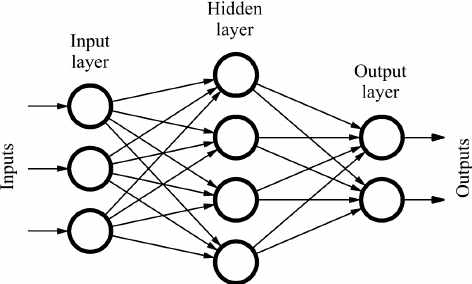

In the function, we have the code below: 

     self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(), 
            #nn.Dropout(0.5),
            nn.Linear(H, D_out) 
        )

An artificial neuron is a function $f_j$ of the input $x = (x_1,...,x_d)$ weighted by a vector of connection weights $wj = (w_{j,1},...,w_{j,d})$, completed by a neuron bias $b_j$, and associated to an activation function $\phi$, namely $y_j = f_j(x) = \phi(〈w_j,x〉+ b_j)$ (see image below)

`nn.Linear(in_features, out_features, bias=True)` applies a linear transformation  to the incoming data: $y=x A^T+b$ with $A$ the matrix of weigths and $b$ the biais to be trained (the weights and the biais are the parameters of the model to determine while training). Then as we apply an activation function $\phi$, here the ReLU function (typical function to apply in the hidden layers of a neural network). Then again another set of weights and biais with the second `nn.Linear()` function.



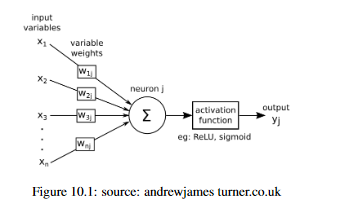

#### b. Functions to **save** the model's state

In [ ]:
# Functions to save and load our fine-tuned BERT model 
# to resume training from where it left off. 
#----------------------------------------------------
def save_ckp(state,name=""):
  """
  This function saves the state of the model to the specified checkpoint directory.
  ---> input:
  - state: current state of the model
  - name (string): string involved in the construction of "checkpoint_name" 
  ---> ouput:
  - checkpoint_name: name of the saved model
  """
  checkpoint_dir  = PATH + '/5_Checkpoints_pt'
  # save to pytorch format(.pt)
  checkpoint_name =  NOW + name + '_checkpoint.pt' 
  #checkpoint_name = checkpoint_dir + '/' + NOW + name + '_checkpoint.pt' 
  #f_path = checkpoint_name
  f_path = checkpoint_dir + '/' + checkpoint_name
  torch.save(state, f_path)
  return checkpoint_name

def load_ckp(checkpoint_fpath, model):
  """
  This function loads a fine-tune model to the specified checkpoint directory.
  Now we can simply pass this model, to our training loop 
  so that the model resumes training from where it left off.
  """
  checkpoint = torch.load(checkpoint_fpath,map_location=device) 
  model.load_state_dict(checkpoint['state_dict'])
  return model, checkpoint['epoch']

# documentation:
# https://medium.com/analytics-vidhya/saving-and-loading-your-model-to-resume-training-in-pytorch-cb687352fa61
# above function can be improved by saving the best model (see doc)

#### c. Function to **initialize** the model

To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:
- Batch size: 16 or 32
- Learning rate (Adam): 5e-5, 3e-5 or 2e-5
- Number of epochs: 2, 3, 4

Huggingface provided the `run_glue.py` script (https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109) , an examples of implementing the transformers library. In the script, the AdamW optimizer is used

In [ ]:
def initialize_model(train_dataloader,epochs=4,resume_training=False,ckp_path=None,lr=5e-5,eps=1e-8):
  """
  Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
  ---> input:
  - train_dataloader: PyTorch train DataLoader
  - epochs (integer): number of epochs to train the model
  - resume_training (bool): if True, the model is initialized with an already fine-tuned model to 
    resume training from where it left off.
  - ckp_path (string): path of the directory to retrieve the already fine-tuned model in case 
  resume_training = True.
  - lr  (float): 5e-5 = Default learning rate in AdamW optimizer 
  - eps (float): 1e-8 = Default epsilon value in AdamW optimizer
  ---> ouput: 
  - bert_classifier
  - optimizer
  - scheduler
    """
  # Instantiate Bert Classifier (using our own BertClassifier class defined above)
  bert_classifier = BertClassifier(freeze_bert=False)

  # Tell PyTorch to run the model on GPU
  bert_classifier.to(device)

  #=======================================
  # if we want to resume training, we initialise our model 
  # with the parameters of the an already fine-tuned model.
  if resume_training:
    # Load the already fine-tuned model
    bert_classifier, start_epoch = load_ckp(ckp_path, bert_classifier)
    print ("Resumed model operational for further training.\nThis model has already been trained with {} epochs.".format(start_epoch))
  #=======================================

  # Create the optimizer (using AdamW optimizer)
  optimizer = AdamW(bert_classifier.parameters(),
                    lr=lr,    
                    eps=eps)

  # Total number of training steps
  total_steps = len(train_dataloader) * epochs #nb of batches * nb of epochs

  # Set up the learning rate scheduler
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                              num_warmup_steps=0, # Default value
                                              num_training_steps=total_steps)
      #scheduler: creates a schedule with a learning rate that decreases linearly 
      #from the initial lr set in the optimizer to 0, after a warmup period during
      #which it increases linearly from 0 to the initial lr set in the optimizer.
      
  return bert_classifier, optimizer, scheduler

Remeber that stochastic gradient descent +  the back-propagation of error algorithms together are used to train neural network models. 

Thus, the **Adam optimization algorithm** is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision and natural language processing. It is used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data. 
https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/


The **learning rate** is a hyperparameter used in the computation of the gradient (gradient present in every Neural Network) that controls how much to change the model in response to the estimated error each time the model weights are updated. Its calibration is very important for the con-
vergence of the algorithm. If it is too small, the convergence is very slow and the optimization can be blocked on a local minimum. If the learning rate is too large, the network will oscillate around an optimum without stabilizing and converging. 

**epsilon** is a very small number to prevent any division by zero in the implementation.


#### d. Function to **train** the model

We will train our Bert Classifier for 4 epochs (or maybe less...). In each epoch, we will train our model and evaluate its performance on the validation set. In more details, we will:

Training:
- Unpack our data from the dataloader and load the data onto the GPU
- Zero out gradients calculated in the previous pass
- Perform a forward pass to compute logits and loss
- Perform a backward pass to compute gradients (loss.backward())
- Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
- Update the model's parameters (optimizer.step())
- Update the learning rate (scheduler.step())

Evaluation:
- Unpack our data and load onto the GPU
- Forward pass
- Compute loss and accuracy rate over the validation set

The script below is commented with the details of our training and evaluation loop.


In [ ]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss() # use cross-entropy because we are in a multi-class classification task

def set_seed(seed_value=42):
  """
  Set seed for reproducibility.
  """
  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False,save_model=True):
  """
  Train the BertClassifier model.
  ---> input:
  - model: the model from our bertClassifier class
  - train_dataloader: PyTorch train DataLoader
  - val_dataloader: PyTorch validation DataLoader if evaluation=True
  - epochs (int): number of epochs to train the model
  - evaluation (bool): if True, evaluate the model after each epoch on the validation set 
  if one is provided by variable "val_dataloader"
  - save_model (bool): if True, saves all parameters of the model to resume training.
  ---> ouput: 
  - the variable "model" (=our BertClassifier model) is modified (=trained) by this function.
  - valLossList (list): list containing the "val_loss" value after each epoch
  - valAccuList (list): list containing the "val_accuracy" value after each epoch
  - checkpoint_name (string): name of the saved model
  """
  valLossList = [] #to save val_loss value after each epoch
  valAccuList = [] #to save val_accuracy value after each epoch

  #----------[ START training loop for each epochs 
  print("Start training...\n")
  for epoch_i in range(epochs):
    # =======================================
    #               Training
    # =======================================
    # Print the header of the result table
    print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}") #^7: size of the displayed cell
    print("-"*70)

    # Measure the elapsed time of each epoch
    t0_epoch, t0_batch = time.time(), time.time()

    # Reset tracking variables at the beginning of each epoch
    total_loss, batch_loss, batch_counts = 0, 0, 0

    # Put the model into the training mode
    model.train()

    # For each batch of training data...
    #-----[ START loop through each batch
    for step, batch in enumerate(train_dataloader): # At each step, m = "batch_size" training examples are randomly chosen without replacement.
                                                    # This samples are stored in the variable batch
                                                    # There are as many steps as there are batches
                                                    # here a batch contains m input_ids, m attention_masks and m labels
      batch_counts +=1
     
      # Load batch to GPU
      b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch) 

      # Zero out any previously calculated gradients
      model.zero_grad()

      # Perform a forward pass. This will return logits 
      # logits = output of the neural network before going through the softmax/sigmoid activation function
      # it is the output of function "forward" in the class "BertClassifier"
      logits = model(b_input_ids, b_attn_mask)

      # Compute loss and accumulate the loss values
      loss = loss_fn(logits, b_labels) 
      batch_loss += loss.item()
      total_loss += loss.item()

      # Perform a backward pass to calculate gradients
      loss.backward()

      # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Update parameters and the learning rate
      optimizer.step() # update parameters
      scheduler.step() # update learning rate 

      # Print the loss values and time elapsed for every 20 batches
      if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
        # Calculate time elapsed for 20 batches
        time_elapsed = time.time() - t0_batch

        # Print training results
        print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

        # Reset batch tracking variables
        batch_loss, batch_counts = 0, 0
        t0_batch = time.time()

      #-----] END loop through each batch
      
    # Calculate the average loss over the entire training data
    avg_train_loss = total_loss / len(train_dataloader)

    print("-"*70)
    # =======================================
    #               Evaluation
    # =======================================
    if evaluation == True:
      # After the completion of each training epoch, measure the model's performance
      # on our validation set.
      val_loss, val_accuracy = evaluate(model, val_dataloader)
      valLossList.append(val_loss)
      valAccuList.append(val_accuracy)

      # Print performance over the entire training data
      time_elapsed = time.time() - t0_epoch
        
      print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
      print("-"*70)
    print("\n")

    # =======================================
    #              Checkpoint
    # =======================================
    # If save_model = True, 
    # After the completion of each epoch, saves de model in the desired location
    # so that the fine-tuned model can be re-used later to resume training
    if save_model: 
      checkpoint = {
      'epoch': epoch_i + 1,
      'state_dict': model.state_dict()}

      if evaluation == True: # If evaluation = True, specify that the checkpoint  
                             # is from a model trained on the train set only 
        check_name = "_eval" 

      else: # else, specify that the checkpoint is from a model
            # trained on train set + validation set
        check_name = "_full"

      checkpoint_name = save_ckp(checkpoint,check_name)

  #----------] END training loop for each epochs 

  print("Training complete!")
  return valLossList,valAccuList,checkpoint_name

def evaluate(model, val_dataloader):
  """
  After the completion of each training epoch, measure the model's performance
  on our validation set.
  """
  # Put the model into the evaluation mode. The dropout layers are disabled during
  # the test time.
  model.eval()

  # Tracking variables
  val_accuracy = []
  val_loss = []

  # For each batch in our validation set...
  for batch in val_dataloader:
    # Load batch to GPU
    b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
    
    # Compute logits
    with torch.no_grad(): #disabled gradient calculation
      logits = model(b_input_ids, b_attn_mask)

      # Compute loss
      loss = loss_fn(logits, b_labels)
      val_loss.append(loss.item())

      # Get the predictions
      preds = torch.argmax(logits, dim=1).flatten()

      # Calculate the accuracy rate
      accuracy = (preds == b_labels).cpu().numpy().mean() * 100
      val_accuracy.append(accuracy)

  # Compute the average accuracy and loss over the validation set.
  val_loss = np.mean(val_loss)
  val_accuracy = np.mean(val_accuracy)

  return val_loss, val_accuracy

### 4.5. Train model on Train set + evaluation on Val set

Now, let's start training our BertClassifier

#### a. Initialise model


##### a.1 Initialise new model

In [ ]:
RESUME = False; CKP_NAME="";  PHASE = 1 # do not change
# =======================================
# INITIALISE MODEL:
# =======================================
NUM_EPOCHS = 2

#-- indicate the parameters in the AdamW optimizer
EPS = 1e-8 # Default epsilon value in AdamW optimizer
LR = 5e-5  # Default learning rate in AdamW optimizer 
#-- Set seed for reproducibility
set_seed(42)   

bert_classifier, optimizer, scheduler = initialize_model(train_dataloader, epochs=NUM_EPOCHS, lr=LR, eps=EPS)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

##### a.2. Initialise with resumed model

In [ ]:
RESUME = True; FULL_RUN = False; PHASE = 1 # do not change
# =======================================
# RESUME MODEL:
# =======================================
# To do this, make sure to run the code in the sections:
# 1
# 2.1
# 3
# 4.4  /.\ Beware to put the correct NUM_LABELS /.\

#----- Make sure that the DATES in the names below are the SAME: 
#-- name of the train_dataloader to resume:
val_dataloader_name = "2022-07-28_16:40:30_val_dataloader" 
#-- name of the val_dataloader to resume:
train_dataloader_name = "2022-07-28_16:40:30_train_dataloader"
#-- name of the fine-tuned to resume:
CKP_NAME = '2022-07-28_16:40:30_eval_checkpoint' 

#-- indicate the number of epochs to make in the next training:
NUM_EPOCHS = 1

#-- indicate the parameters in the AdamW optimizer
EPS = 1e-8 # Default epsilon value in AdamW optimizer
LR = 5e-5  # Default learning rate in AdamW optimizer 

#-- Redefine some global variables if not already defined: 
BERT_MODEL_NAME = 'bert-base-uncased'

#----- Load train_dataloader and val_dataloader
os.chdir(PATH + '/3_DataLoader_pt') #go to correct folder 
train_dataloader = torch.load(train_dataloader_name + ".pt") #load info
val_dataloader = torch.load(val_dataloader_name + ".pt") #load info
os.chdir(PATH) #return to main folder 

#----- Initlialize the model with resumed fine-tuned BERT model 
bert_classifier, optimizer, scheduler = initialize_model(
      train_dataloader, epochs = NUM_EPOCHS ,resume_training = True,
      ckp_path = PATH + '/5_Checkpoints_pt/' + CKP_NAME + ".pt",lr=LR,eps=EPS)

FileNotFoundError: ignored

#### b. Train model on Train set

In [ ]:
FULL_RUN = False # do not change
# =======================================
# TRAIN MODEL:
# =======================================
NOW = time.strftime("%Y-%m-%d_%H:%M:%S")

valLossList,valAccuList,checkpoint_name = train(bert_classifier, train_dataloader, val_dataloader, epochs=NUM_EPOCHS, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.680802   |     -      |     -     |   15.41  
   1    |   40    |   0.618168   |     -      |     -     |   15.10  
   1    |   60    |   0.635223   |     -      |     -     |   15.47  
   1    |   80    |   0.356148   |     -      |     -     |   15.40  
   1    |   100   |   0.605691   |     -      |     -     |   15.08  
   1    |   120   |   0.477335   |     -      |     -     |   14.98  
   1    |   140   |   0.559744   |     -      |     -     |   14.98  
   1    |   160   |   0.519840   |     -      |     -     |   15.12  
   1    |   180   |   0.471557   |     -      |     -     |   15.21  
   1    |   200   |   0.428075   |     -      |     -     |   15.16  
   1    |   220   |   0.467264   |     -      |     -     |   15.11  
   1    |   240   |   0.404632   |     -      |     -     |   15.03  


__About the loss function:__ \
The loss funtion used in classification tasks is usually the **Cross-Entropy**. Minimizing this loss function is equivalent to maximizing the log-likelihood.  In python, this function is used as the following: \

- **input**: contains raw, unnormalized scores for each class \
i.e. contains the **logits** which are the outputs of a layer of a neural network before going through the softmax/sigmoid activation function ( = before computing the probability). \

  input has to be a *Tensor* of size: $N \times C$ where: \
  $N$: size of the batch \
  $C$: number of classes.

- **target**: contains the class indices that must be in the range $[0,C[$ so here the class indices must take the values: $0,1,2$

  Target has to be a *Tensor* of size $C$

- If provided, the optional argument **weight** should be a 1D *Tensor* assigning weight to each of the classes. This is particularly useful when you have an unbalanced training set.

Python doc: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

#### c. Get predictions on Validation Set

The prediction step is similar to the evaluation step that we did in the training loop, but simpler. We will perform a forward pass to compute logits and apply softmax to calculate probabilities.

____________________

*Reminder:* In **multi-class** classification each sample is assigned to one and only one label. In **multi-label** case each sample can belong to one or more than one class. \
Here we are in a **multi-class** classification problem.

____________________


__About the activation function for the last layer:__ \

For the last layer of the neural networks, there is 2 common activation functions:

- sigmoid function: $\sigma(x) = \frac{1}{1+e^{-x}}$ \
> input domain: $]-\infty, +\infty[$ \
> output range: $[0, 1]$ \

  The sigmoid activation function is generally considered for binary classification since its output value is in $[0, 1]$.  
  But this function can also be used in multi-label classification where we use sigmoid() instead of softmax() to get the probabilities. \
  In simple binary classification, there’s no big difference between sigmoid() and softmax(), however in case of multi-labels classification, sigmoid allows to deal with non-exclusive labels while softmax deals with exclusive classes.

- softmax function: $\sigma(x)_i = \frac{e^{x_i}}{\sum_{j=1}^{K}e^{x_j}}$
> input: vector $x$ of $K$ real numbers \
> output: vector of probabilities = probability distribution of $K$ possible outcomes.

  This is the activation function that we will use to compute the probabilities.


**NOTE:** We will use this activation function for GETTING PREDICTIONS from our model but NOT for TRAINING our model.


In [ ]:
def bert_predict(model, test_dataloader):
    """
    This function performs a forward pass on the trained BERT model to predict probabilities
    on the test set.
    ---> output: probs (array): probability for each comment to belong to each class
    of size number of comments * number of classes (=3)
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad(): #no gradient computation
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

In [ ]:
#----- Pickle Probs results for later use 
os.chdir(PATH + '/4_ProbsValSet_pkl') #go to correct folder 
pd.DataFrame(probs).to_pickle(NOW + "_probsVal.pkl") #pickle dataset
os.chdir(PATH) #return to main folder

#----- Retrieve Probs results  
"""
probs_name = ""

os.chdir(PATH + '/4_ProbsValSet_pkl') #go to correct folder 
probs = pd.read_pickle(probs_name + '.pkl')
"""

'\nprobs_name = ""\n\nos.chdir(PATH + \'/4_ProbsValSet_pkl\') #go to correct folder \nprobs = pd.read_pickle(probs_name + \'.pkl\')\n'

#### d. Evaluation on Validation set

In [ ]:
def predictionRule(probs,rule=1,T=0.5):
  """
  This function computes the final label for our dataset.
  ---> input: 
  - probs (np.array): array of size (nb_comments * 3) containing 
  the probability that each comment belongs to each class.
  - rule (integer): can take values 1 or 2 and indicates
  which prediction rule to use.
  ---> ouput: 
  - predLabel (np.array): array of size (nb_comments) containing the 
  predicted label (positive: 2, neutral: 1, negative: 0) for each comment.
  * With rule = 1, the label predicted is the one with the highest probability. 
  * With rule = 2, the label predicted is also the one with the highest probability.
  However, if the absolute difference between the probabilities is < T, 
  there is confusion between the probabilities and the label is put to 1 (neutral).
  """

  ###### Rule 1 ######
  predLabel = np.argmax(probs,axis = 1) 
  # for the first label prediction,
  # the class with the highest probability is predicted
  
  ###### Rule 2 ######
  if rule == 2: 
    if NUM_LABELS == 3:
      diffs = np.array([abs(probs[:,0] - probs[:,1]),
                        abs(probs[:,0] - probs[:,2]),
                        abs(probs[:,1] - probs[:,2])]).T
    elif NUM_LABELS == 2:
      diffs = np.array([abs(probs[:,0] - probs[:,1])]).T

    # col0: absolute difference between col0 and col1 of probs
    # col1: absolute difference between col0 and col2 of probs
    # col2: absolute difference between col1 and col2 of probs

    toChange = np.all(diffs < T*np.ones((diffs.shape)),axis = 1) 
    # array containing true for the comments where the absolute difference
    # between all 3 probabilities is < T

    predLabel[np.where(toChange)] = 1 
    # change the label to 1 (neutral) if the absolute difference between the probabilities is < T

  return predLabel

In [ ]:
def evaluate_perf(probs,y_true,rule=1,T=0.5):
  """
  This function evaluates the BERT classifier
  ---> input:
  - probs (np.array): probabilities of each comment belonging to each class 
  (output of bert prediction) of size number of comments * number of classes
  - y_true (np.array): true labels 
  ---> output:
  - y_pred (np.array) : predictions of the model: the class with the 
  highest probability is predicted
  - crossT (dataframe): contigency table
  - accuracy (scalar): accuracy of the prediction. The closer this value is to 1, the better the model.
  - f1 (scalar): f1-score of the predictions. The closer this value is to 1, the better the model.
  """

  #y_pred = np.argmax(probs,axis = 1) # the class with the highest probability is predicted
  y_pred = predictionRule(probs,rule,T) # get the predicted labels

  # put results into a dataFrame
  dfResult = pd.DataFrame(y_pred); dfResult
  dfResult.rename(columns = {0 : "Prediction"},inplace = True)
  dfResult["True_label"] = y_true
  
  # computation of the contigency table
  crossT = pd.crosstab(index=dfResult["Prediction"], columns=dfResult["True_label"])

  # computation of the accuracy
  accuracy = accuracy_score(y_true, y_pred)
  print(f'Accuracy: {accuracy*100:.2f}%')
  
  # computation of the f1-score
  f1Score = f1_score(dfResult["True_label"], dfResult["Prediction"],average='macro')
  print(f'F1-Score: {f1Score*100:.2f}%')

  return y_pred, crossT, accuracy, f1Score

In [ ]:
# Evaluate the Bert classifier with the prediction rule 1
#---------------------------------------------------------
print("Evaluation of the Bert classifier with prediction rule 1:")
y_pred_val, crossT, accuracy_val, f1Score_val = evaluate_perf(probs,y_val)
crossT_val = crossT.to_numpy().tolist() #convert crossT to list format for later use 
print("\nContigency Table:")
crossT

In [ ]:
# Evaluate the Bert classifier with the prediction rule 2
#---------------------------------------------------------
def computeBest_T(T_grid,probs,y_val):
  """
  This function computes the best threshold in the function "predictionRule" 
  with the rule 2. The best threshold is the one giving the highest Accuracy
  and F1-Score in the function "evaluate_perf".
  ---> input:
  - T_grif (list): containing th thresholds to test
  ---> ouput:
  - best_T (float): value of the best threshold. 
  """

  accuracy_grid = [] # list containing the Accuracy for each trehshold in T_grid
  F1Score_grid  = [] # list containing the F1-score for each trehshold in T_grid

  for t in T_grid:
    print("threshold: ", t)
    a,b,accuracy_val_2, f1Score_val_2 = evaluate_perf(probs,y_val,rule=2,T=t)
    print("")
    accuracy_grid.append(accuracy_val_2)
    F1Score_grid.append(f1Score_val_2)

  accuracy_grid = np.array(accuracy_grid)
  F1Score_grid  = np.array(F1Score_grid)

  best_T_Acc = np.argmax(accuracy_grid)
  best_T_F1 = np.argmax(F1Score_grid)
  return (T_grid[best_T_Acc])

In [ ]:
T_grid = [.1,.2,.3,.4,.5,.6,.7,.8,.9] # grid of thresholds for the prediction rule 2 
BEST_T = computeBest_T(T_grid,probs,y_val)
print("BEST_T: ", BEST_T)

In [ ]:
# Evaluate the Bert classifier with the prediction rule 2 
# using the Best Threshold found with function "computeBest_T"
#---------------------------------------------------------
print("Evaluation of the Bert classifier with prediction rule 2 using the Best Threshold:")
y_pred_val_2, crossT_2, accuracy_val_2, f1Score_val_2 = evaluate_perf(probs,y_val,rule=2,T=BEST_T)
crossT_val_2 = crossT_2.to_numpy().tolist() #convert crossT_2 to list format for later use 
print("\nContigency Table:")
crossT_2

Evaluation of the Bert classifier with prediction rule 2 using the Best Threshold:
Accuracy: 84.83%
F1-Score: 84.43%

Contigency Table:


True_label,0,1
Prediction,,
0,303,43
1,48,206


<font color = "green"> __You can know jump to section 4.7 and run the cell to save the parameters in an excel file.__ </font>

__Description of the metrics used:__

- The __accuracy score__:  accuracy_score computes the accuracy of correct predictions as follows: 
$$ \text{accuracy}(y,\hat y) = \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}} -1} 1_{\hat y_i = y_i} $$

  where $\hat y_i $ is the predicted value of the $i$-th sample and $y_i$ is the corresponding true value. \
  **This is the same metric as the Purity metric.** \
  The closer the accuracy is to 1, the better the model


### 4.6. Train model on the entire training data

Concatenate train set and validation set: 

In [ ]:
# Concatenate the train set and the test set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=BATCH_SIZE)

In [ ]:
#----- Save dataloader for later use
os.chdir(PATH + '/3_DataLoader_pt') #go to correct folder 
torch.save(full_train_dataloader, NOW + "_full_train_dataloader.pt")
os.chdir(PATH) #return to main folder 

#### a. Initialise model

##### a.1 Initialise new model

In [ ]:
RESUME = False; CKP_NAME=""; PHASE = 1 #do not change
# =======================================
# INITIALISE MODEL:
# =======================================
NUM_EPOCHS = 2

#-- indicate the parameters in the AdamW optimizer
EPS = 1e-8 # Default epsilon value in AdamW optimizer
LR = 5e-5  # Default learning rate in AdamW optimizer 
#-- Set seed for reproducibility
set_seed(42)   

bert_classifier, optimizer, scheduler = initialize_model(full_train_dataloader,epochs=NUM_EPOCHS)

##### a.2. Initialise with resumed model

In [ ]:
RESUME = True; FULL_RUN = True; PHASE = 1  #do not change
# =======================================
# RESUME MODEL:
# =======================================
# To do this, make sure to run the code in the sections:
# 1
# 2.1
# 3
# 4.4  /.\ Beware to put the correct NUM_LABELS /.\

#----- Make sure that the DATES in the names below are the SAME: 
#-- name of the full_train_dataloader to resume:
full_train_dataloader_name = "2022-08-18_10:50:40_full_train_dataloader"
#-- name of the fine-tuned to resume:
CKP_NAME = "2022-08-18_10:50:40_full_checkpoint"

#-- indicate the number of epochs to make in the next training:
NUM_EPOCHS = 2

#-- indicate the parameters in the AdamW optimizer
EPS = 1e-8 # Default epsilon value in AdamW optimizer
LR = 5e-5  # Default learning rate in AdamW optimizer 

#-- Redefine some global variables if not already defined: 
BERT_MODEL_NAME = 'bert-base-uncased'

#----- Load full_train_dataloader
os.chdir(PATH + '/3_DataLoader_pt/bestModels/') #go to correct folder 
full_train_dataloader = torch.load(full_train_dataloader_name + ".pt",map_location=device) #load info
os.chdir(PATH) #return to main folder 

#----- Initlialize the model with resumed fine-tuned BERT model 
bert_classifier, optimizer, scheduler = initialize_model(
      full_train_dataloader, epochs = NUM_EPOCHS ,resume_training = True,
      ckp_path = PATH + '/5_Checkpoints_pt/bestModels/' + CKP_NAME + ".pt",lr=LR,eps=EPS)

Resumed model operational for further training.
This model has already been trained with 2 epochs.


####b. Train model on full dataset

In [ ]:
FULL_RUN = True  #do not change
# =======================================
# TRAIN MODEL:
# =======================================
NOW = time.strftime("%Y-%m-%d_%H:%M:%S")    
          
LossList,AccuList,checkpoint_name = train(bert_classifier, full_train_dataloader, epochs=NUM_EPOCHS)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


   1    |   20    |   0.660482   |     -      |     -     |   17.15  
   1    |   40    |   0.596399   |     -      |     -     |   14.10  
   1    |   60    |   0.471309   |     -      |     -     |   14.28  
   1    |   80    |   0.542923   |     -      |     -     |   14.51  
   1    |   100   |   0.443108   |     -      |     -     |   14.67  
   1    |   120   |   0.313707   |     -      |     -     |   14.97  
   1    |   140   |   0.444618   |     -      |     -     |   15.11  
   1    |   160   |   0.362100   |     -      |     -     |   15.36  
   1    |   180   |   0.485692   |     -      |     -     |   15.63  
   1    |   200   |   0.448361   |     -      |     -     |   15.75  
   1    |   220   |   0.484856   |     -      |     -     |   15.62  
   1    |   240   |   0.358605   |     -      |     -     |   15.50  
   1    |   260   |   0.402628   |     -      |     -     |   15.55  
   1    |   280   |   0.431899   |     -      |     -     |   15.66  
   1    |   300   | 

### 4.7. <font color = "red" > Second fine-tuning on dashboardLabel
> used to fine-tune again our model on 200 labeled comments from the dasboard data. These comments are *different* from the ones in miniLabel dataset wich we will use to evaluate our model.

#### a. Download & formats dashbordLabel dataset

In [ ]:
# Work on the dashbordLabel dataset
#---------------------------------------------
# Download the dashbordLabel dataset
os.chdir(PATH)
data2 = pd.read_excel("data/dashbordLabel.xlsx")

# Clean the dataframe and assign correct type  
data2.index = data2["Unnamed: 0"].astype(int)
data2.index.name = None
data2.drop("Unnamed: 0", axis = 1, inplace = True)
data2["label"] = data2["label"].astype(int)
data2["label"]=pd.Categorical(data2["label"],ordered=False) 
data2.drop ("progress", axis = 1, inplace = True)

NAMES = "dashbordLabel"

We now have a "dashbordLabel" dataset which contains 200 labeled comments. 

We loaded the model that gave the best results on the "miniLabel" dataset (which we will call *bestModel*) in the case of 2 and 3 labels and resumed the training for a second fine-tuning but this time on the "dashbordLabel" dataset. 

It turns out that whatever the number of epochs used in the second fine-tuning (2,4,10,20 epochs) the results were not different from those of the first fine-tuning with the *bestModel*: the probabilities were exactly identical.
This is because the number of comments on which we did the 2nd fine-tuning was too small (only 200 comments). 

We therefore decided to duplicate the "dashbordLabel" dataset several times by concatenating the same dataset several times and then shuffling it. 

With a fixed number of epochs: (2 epochs)

- With a LR of 5e-2, the model overfitted and each row of the probability matrix was identical.

- We then thought of using a much smaller learning rate than normal so that we do not wash away the weights learned on the old data. With a LR of 5e-10, the probabilities were very close to those obtained with the 1st *bestModel* fine-tuning and so the predictions were the same. The LR was too small and the model did not update the parameters enough.

- Finally, a LR of 5e-5 (as recommended in the bert-paper) provided different probabilities and improved predictions.

To be tested:
- play with the LR but always staying within the 3 LR proposed by the bert paper. **DONE**
- play with the number of epochs **DONE**
- instead of concatenating copies of "dashbordLabel", try simple data-augmentation methods. See if it improves the results or not, for the same number of comments in data2
- increase/decrease the size of data2 and see what is better. **DONE** (increase)
- try to do a single fine-tuning by integrating "dashbordLabel" (several times duplicated or increased) to the Kaggle datasets and see if it improves the results 


Could also see: can you weight observations in a neural network?
https://stats.stackexchange.com/questions/326532/can-you-weight-observations-in-a-neural-network

https://machinelearningmastery.com/update-neural-network-models-with-more-data/ 

#### b. Augment dataset

Since the size of "dashbordLabel" is too small to make a difference in the 2nd fine-tuning, we must increase its size.

##### <font color = 'red'> **Method 1:** </font> Concatenate several copies 

In [ ]:
NUM_COPIES = 5 #number of copies of "data2" to make

MIX = str(NUM_COPIES) + " copies of the {} comments of dashbordLabel = {} comments".format(len(data2),NUM_COPIES*len(data2))
print("MIX: ",MIX)

data2 = pd.concat([data2]*NUM_COPIES, axis=0) #concatenate all copies of "data2"
data2 = shuffle(data2) #shuffle dataset

MIX:  7 copies of the 200 comments of dashbordLabel = 1400 comments


##### <font color = 'red'> **Method 2:** </font> Text Data Augmentation



Documentation: for text data augmentation for sentiment analysis (we have to make sure that the augmentation does not change the main sentiment of the texts)

- https://computationalsocialnetworks.springeropen.com/track/pdf/10.1186/s40649-020-00080-x.pdf

- https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9543519&casa_token=EnD1Wh4tj90AAAAA:KcT6IIJj8O73B8ZIVc0LVk10aj_K2DgVUD0vgbi5Yi7TjxI9O9gH492UDcC0gDD_9BlyFNAuafiD (best paper)

- https://github.com/makcedward/nlpaug#augmenter (github repo)

=> **conclusion of these papers**: USE **BT (back-translation)** for data augmentation in the case of **small** and **imbalanced** datasets with **BERT**.



https://aclanthology.org/2021.emnlp-main.362.pdf -> new approach but maybe complicated


However, increasing the text with the BT is not enough as we want to reach at least 5*200 comments = 1000 comments.
We then use textual augmentation by Word embeddings which may not be the best solution but will increase the data further.  After several tests on our comments, I think that the method with Word embedding is still more efficient than the simple synonym replacement.

In [ ]:
"""# Install Transformers from source with the following command:  
# - We need to do this to use "back_translation" with "nlpaug", otherwise it does not work.
# - May need to restart runtime environment since "transformers==2.8.0" version has  
#   been previously loaded for BERT fine-tuning. 
#-------------------------------------------------
!pip install git+https://github.com/huggingface/transformers

# Install other libraries 
#-------------------------------------------------
!pip install sacremoses
!pip install sentencepiece

# Install nlpaug library
#-------------------------------------------------
#!pip install numpy requests nlpaug"""

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-a71a7key
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-a71a7key
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
"""#Import nlpaug library
#-------------------------------------------------
import nlpaug.augmenter.word as naw

# Dowload the back_translation model.
#-------------------------------------------------
#---  Use english_german translation (default model) 
back_translation_aug_de = naw.BackTranslationAug(device = device.type,
    from_model_name='facebook/wmt19-en-de', #english-deutch 
    to_model_name='facebook/wmt19-de-en'    #deutch-english 
)

#--- Use english-french translation 
back_translation_aug_fr = naw.BackTranslationAug(device = device.type,
    from_model_name='Helsinki-NLP/opus-mt-en-fr', #english-french 
    to_model_name='Helsinki-NLP/opus-mt-fr-en'    #french-english 
)

#--- Use english-chinese translation 
back_translation_aug_zh = naw.BackTranslationAug(device = device.type,
    from_model_name='Helsinki-NLP/opus-mt-en-zh', #english-chinese 
    to_model_name='Helsinki-NLP/opus-mt-zh-en'    #chinese-english 
)

# documentation on naw.BackTranslationAug: 
# https://nlpaug.readthedocs.io/en/latest/augmenter/word/back_translation.html


# Dowload the contextual word embeddings model.
# Substitute word by contextual word embeddings (here with BERT)
#-------------------------------------------------
context_embedding_aug = naw.ContextualWordEmbsAug(device = device.type,
    model_path='bert-base-uncased', action="substitute")"""

In [ ]:
"""text = 'The quick brown fox jumped over the lazy dog'
print("Testing the imported augmenting methods: ")
print("-----------------------------------------")
print("Original text: ",text)
print("BT english-deutch: ",back_translation_aug_de.augment(text))
print("BT english-french: ",back_translation_aug_fr.augment(text))
print("BT english-chinese: ",back_translation_aug_zh.augment(text))
print("Context word embedding (BERT) :",context_embedding_aug.augment(text))"""

Testing the imported augmenting methods: 
-----------------------------------------
Original text:  The quick brown fox jumped over the lazy dog
BT english-deutch:  ['The speedy brown fox leapt over the lazy dog']
BT english-french:  ['The fast brown fox jumped on the lazy dog']
BT english-chinese:  ['Fast brown fox skips a lazy dog, skips a lazy dog.']
Context word embedding (BERT) : ['as frightened brown fox jumped over the lazy to']


In [ ]:
def augmentText(data2,method_aug):
  """
  this function augments the text data with the method provided
  ---> input:
  - data2 (dataFrame): dataframe containing 2 columns {"commments", "label"}
  - method_aug: method for text augmentation
  ---> ouput:
  - aug_data2 (dataFrame): dataframe with the same dimensions as data2 containing
  the modified "comments" with the augmented method and the corresponding label
  """
  aug = [] #list of the augmented comments in the same order as the comments in data2

  print("Beginning of augmentation...\n")
  for i in range(len(data2)):
    if i % 10 == 0: #print every 10 comments 
      print("comment ",i)
    text = data2.comments.iloc[i]
    aug.append(method_aug.augment(text))  

  aug_data2 = pd.DataFrame(aug)
  aug_data2.rename(columns={0:"comments"},inplace=True)
  aug_data2.index = data2.index
  aug_data2["label"] = data2["label"].copy()
  print("\ndone!")
  return aug_data2 

In [ ]:
# Compute augmented datasets
#---------------------------------------
"""aug_eng_de = augmentText(data2,back_translation_aug_de); name_eng_de = "200_eng-de"
#aug_eng_fr = augmentText(data2,back_translation_aug_fr); name_eng_fr = "200_eng-fr"
#aug_eng_zh = augmentText(data2,back_translation_aug_zh); name_eng_fr = "200_eng-zh"
#aug_embedding = augmentText(data2,context_embedding_aug); name_embedding = "200_embeddings"

#----- Pickle dataset for later use 
os.chdir(PATH + '/7_Augmented_pkl') #go to correct folder 
pd.DataFrame(aug_eng_de).to_pickle(name_eng_de + ".pkl") #pickle dataset
os.chdir(PATH) #return to main folder"""

In [ ]:
# Augmenting pipeline
#---------------------------------------
aug_dataS = [] #list containing the dataframe which are augmented from data2

#----- Retrieve augmented datasets 
os.chdir(PATH + '/7_Augmented_pkl') #go to correct folder 

#-- append data2
MIX = "200_original"
aug_dataS.append(data2)
#-- append augment data english-deuth BT 
MIX += "+200_eng-de"
aug_dataS.append(pd.read_pickle("200_eng-de" + '.pkl'))

MIX += "+200_eng-de"
aug_dataS.append(pd.read_pickle("200_eng-de" + '.pkl'))
#-- append augment data english-french BT 
MIX += "+200_eng-fr"
aug_dataS.append(pd.read_pickle("200_eng-fr" + '.pkl'))

MIX += "+200_eng-fr"
aug_dataS.append(pd.read_pickle("200_eng-fr" + '.pkl'))
#-- append augment data english-chinese BT 
MIX += "+200_eng-zh"
aug_dataS.append(pd.read_pickle("200_eng-zh" + '.pkl'))
#-- append augment data context word embedding 
MIX += "+200_embeddings"
aug_dataS.append(pd.read_pickle("200_embeddings" + '.pkl'))

os.chdir(PATH) #return to main folder

print("MIX: ",MIX)

#----- Concatenate all datasets into data2
data2 = pd.concat(aug_dataS, axis=0)

print ("Size of the augmented dataset: ", len(data2))

MIX:  200_original+200_eng-de+200_eng-de+200_eng-fr+200_eng-fr+200_eng-zh+200_embeddings
Size of the augmented dataset:  1400


#### c. Tokenization

In [ ]:
# If we want 2 labels, we replace: 0 -> 0 and 1,2 -> 1 so that we have
# labels (negative,positive) instead of (negative,neutral,positive)
if NUM_LABELS == 2: 
  data2.label.iloc[np.where(data2.label != 0)] = 1
data2.tail()

,comments,label
2664,so has progressed well and since has done work...,1
178,implemented linear controls but no dataset or ...,1
8745,"math game and computation model is level one, ...",0
9829,"met discussed project priority, proposal to fi...",0
6837,the past week : jack : researched the open off...,1


In [ ]:
2# Separate comments and labels
#---------------------------------------------
X_train2 = data2["comments"].values
y_train2 = data2["label"].values

In [ ]:
# Run function `preprocessing_for_bert` 
#---------------------------------------------
preprocessing_for_bert = preprocessingForBert_long
print("Now run the function "  + preprocessing_for_bert.__name__ + " on the dataset:\n")
print('Tokenizing data...')
train_inputs2, train_masks2 = preprocessing_for_bert(X_train2)
print("Done!")

Now run the function preprocessingForBert_long on the dataset:

Tokenizing data...
Done!


#### d. Create Pytorch dataLoader

In [ ]:
BATCH_SIZE = 8

# Convert other data types to torch.Tensor
train_labels2 = torch.tensor(y_train2)

# Create the DataLoader for our training set
train_data2 = TensorDataset(train_inputs2, train_masks2, train_labels2)
train_sampler2 = RandomSampler(train_data2) 
train_dataloader2 = DataLoader(train_data2, sampler=train_sampler2, batch_size=BATCH_SIZE)

# Save current time
NOW = time.strftime("%Y-%m-%d_%H:%M:%S")

In [ ]:
#----- Save dataloader for later use
os.chdir(PATH + '/3_DataLoader_pt') #go to correct folder 
torch.save(train_dataloader2, NOW + "_full_train_dataloader.pt")
os.chdir(PATH) #return to main folder 

#### d. Resume the best model 

We resume the model that gave the best predictions on the "miniLabel" dataset to fine-tune further but this time, on our augmented "dashbordLabel" dataset.

In [ ]:
RESUME = True; FULL_RUN = True; PHASE = 2 #do not change
# =======================================
# RESUME MODEL:
# =======================================
# To do this, make sure to run the code in the sections:
# 1
# 2.1
# 3
# 4.4  /.\ Beware to put the correct NUM_LABELS /.\

#-- name of the fine-tuned to resume:
CKP_NAME = "2022-08-09_09:30:18_full_checkpoint"

#-- indicate the number of epochs to make in the next training:
NUM_EPOCHS = 2

#-- indicate the parameters in the AdamW optimizer
EPS = 1e-8 # Default epsilon value in AdamW optimizer
LR = 5e-5  # Default learning rate in AdamW optimizer 
#values proposed by the BERT paper: 5e-5, 3e-5 or 2e-5

#-- Redefine some global variables if not already defined: 
BERT_MODEL_NAME = 'bert-base-uncased'

#----- Initlialize the model with resumed fine-tuned BERT model 
bert_classifier, optimizer, scheduler = initialize_model(
      train_dataloader2, epochs = NUM_EPOCHS ,resume_training = True,
      ckp_path = PATH + '/5_Checkpoints_pt/' + CKP_NAME + ".pt",lr=LR,eps=EPS)

Resumed model operational for further training.
This model has already been trained with 2 epochs.


#### e. Train the model for a 2nd fine-tuning

In [ ]:
FULL_RUN = True  #do not change
# =======================================
# TRAIN MODEL:
# =======================================
LossList,AccuList,checkpoint_name= train(bert_classifier, train_dataloader2, epochs=NUM_EPOCHS)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.313214   |     -      |     -     |   15.09  
   1    |   40    |   0.144707   |     -      |     -     |   14.59  
   1    |   60    |   0.292513   |     -      |     -     |   14.95  
   1    |   80    |   0.189508   |     -      |     -     |   15.21  
   1    |   100   |   0.441477   |     -      |     -     |   15.61  
   1    |   120   |   0.113018   |     -      |     -     |   15.70  
   1    |   140   |   0.043425   |     -      |     -     |   15.46  
   1    |   160   |   0.059797   |     -      |     -     |   15.19  
   1    |   174   |   0.139497   |     -      |     -     |   10.63  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-------------------------------------------------------------------

### 4.8. Save parameters in excel

In [ ]:
# =======================================
# Open file and initalise variables
# =======================================
#----- Open xlsx file
os.chdir(PATH) #go to correct folder 
wb = load_workbook(filename = PATH + "/result/BERT_runs_2.xlsx")
#----- Get the current Active Sheet
ws = wb.active #or wb['SHEET_NAME']
#----- Specify row index
row = 2
#----- If there is no first run (true only at the first use) 
if not(ws.cell(row,1).value): 
  ws.cell(row,1).value = 1 
else: #increase number of runs 
  ws.cell(row,1).value = ws.cell(row,1).value + 1 
#----- Update row index according to the number of runs and update col
row = int(ws.cell(row,1).value) + 2

# =======================================
# Write information
# =======================================
#--Write date 
ws.cell(row,2).value = NOW

#--Write number of epochs
ws.cell(row,11).value = NUM_EPOCHS

#--Write eps value in AdamW optimizer
ws.cell(row,12).value = EPS
#--Write lr value in AdamW optimizer
ws.cell(row,13).value = LR

#--Write the number of labels
ws.cell(row,23).value = NUM_LABELS

#-----[ The model has been resumed 
if RESUME:
  #--Write that the model was resumed
  ws.cell(row,3).value = "Y"
  ws.cell(row,4).value = CKP_NAME

  #--If we are in the 2nd phase of fine-tuning (on "dashbordLabel"):
  if PHASE == 2:
    #--Write that we are using dataset "dashbordLabel"
    ws.cell(row,6).value = str(NAMES)
    #--Write dataset mix
    ws.cell(row,8).value = MIX
     #--Write BERT model name
    ws.cell(row,9).value = BERT_MODEL_NAME
    #--Write Batch size
    ws.cell(row,10).value = BATCH_SIZE

  if not(FULL_RUN): 
    
    #--Write val_loss in BERT Pre-training (with valisation set)
    ws.cell(row,14).value = str(valLossList)
    #--Write val_accuracy in BERT Pre-training (with valisation set)
    ws.cell(row,15).value = str(valAccuList)

    ########## Prediction RULE 1 
    #--Write Bert accuracy on validation set
    ws.cell(row,16).value = accuracy_val
    #--Write Bert Cross Table on validation set
    ws.cell(row,17).value = str(crossT_val)
    #--Write Bert F1-score on validation set
    ws.cell(row,18).value = f1Score_val
    ########## Prediction RULE 2 (BEST threshold) 
    #--Write Best trheshold 
    ws.cell(row,19).value = str(BEST_T)
    #--Write Bert accuracy on validation set 
    ws.cell(row,20).value = accuracy_val_2
    #--Write Bert Cross Table on validation set
    ws.cell(row,21).value = str(crossT_val_2)
    #--Write Bert F1-score on validation set
    ws.cell(row,22).value = f1Score_val_2

#-----]  

#-----[ the model was not resumed
else:
  #--Write that the model was not resumed
  ws.cell(row,3).value = "N"
  ws.cell(row,4).value = ""

  #--Write dataset names
  ws.cell(row,6).value = str(NAMES)
  #--Write dataset urls
  ws.cell(row,7).value = str(URLS)
  #--Write dataset mix
  ws.cell(row,8).value = MIX

  #--Write BERT model name
  ws.cell(row,9).value = BERT_MODEL_NAME
  #--Write Batch size
  ws.cell(row,10).value = BATCH_SIZE
  
  #--Write if the model was trained on the full dataset
  if FULL_RUN:
    ws.cell(row,5).value = "Full"
  else:
    ws.cell(row,5).value = "Train"
    
    #--Write val_loss in BERT Pre-training (with valisation set)
    ws.cell(row,14).value = str(valLossList)
    #--Write val_accuracy in BERT Pre-training (with valisation set)
    ws.cell(row,15).value = str(valAccuList)
  
    ########## Prediction RULE 1 
    #--Write Bert accuracy on validation set
    ws.cell(row,16).value = accuracy_val
    #--Write Bert Cross Table on validation set
    ws.cell(row,17).value = str(crossT_val)
    #--Write Bert F1-score on validation set
    ws.cell(row,18).value = f1Score_val
    ########## Prediction RULE 2 (BEST threshold) 
    #--Write Best trheshold 
    ws.cell(row,19).value = str(BEST_T)
    #--Write Bert accuracy on validation set 
    ws.cell(row,20).value = accuracy_val_2
    #--Write Bert Cross Table on validation set
    ws.cell(row,21).value = str(crossT_val_2)
    #--Write Bert F1-score on validation set
    ws.cell(row,22).value = f1Score_val_2

#-----]

# =======================================
# WRITE now all changes into the file 
# =======================================
wb.save(PATH + "/result/BERT_runs_2.xlsx")

In [ ]:
# =======================================
# Update CKP_NAME name if the training has been RESUMED and there was a SECOND fine-tuning. 
# Otherwise, let inchanged. 
# This will be useful in the part were we work on the "miniLabel" dataset
# =======================================
if RESUME: 
    CKP_NAME = NOW + "_full_checkpoint" 

Interface to try to save every parameters for each run(same use as the excel file): **Comet**

In [ ]:
#----- Empty cache to avoid memory problems
torch.cuda.empty_cache()

## 5.Apply BERT on our own Datasets

In [ ]:
# =======================================
# Before running the cells below:
# =======================================
##### 1. Make sure you have fine-tuned a BERT model: 
# a) Resume a model in section 4.5.a.2. or section 4.6.a.2. (recommended)
# b) Use a model fine-tuned in the same run of this Notebook.

##### 2. Make sure to run the code in the sections:
# 1
# 2.1  
# 2.5
# 4.1
# 4.2
# 4.5.c. functions "bert_predict", "predictionRule", "evaluate_perf" and "computeBest_T"

### 5.1. Download our own datasets (3 options: A,B or C)

---



#### Option A. Download the miniLabel (validation) dataset 
> used to **evaluate** our model on 30 comments from the dashboard data in order to perform model selection. 

In [ ]:
# Work on the miniLabel(validation) dataset
#---------------------------------------------
# Download the miniLabel dataset
os.chdir(PATH)
dash_data = pd.read_excel("data/miniLabel.xlsx")

# Clean the dataframe and assign correct type  
dash_data.index = dash_data["Unnamed: 0"].astype(int)
dash_data.index.name = None
dash_data.drop("Unnamed: 0", axis = 1, inplace = True)
dash_data["label"] = dash_data["label"].astype(int)
dash_data["label"]=pd.Categorical(dash_data["label"],ordered=False) 
dash_data.rename(columns = {"label": "TrueLabel"},inplace = True)

# If we want 2 labels, we replace: 0 -> 0 and 1,2 -> 1 so that we have
# labels (negative,positive) instead of (negative,neutral,positive)
if NUM_LABELS == 2: 
  dash_data.TrueLabel.iloc[np.where(dash_data.TrueLabel != 0)] = 1

#### Option B. Download the Test dataset 
> used to **Test** our model on 50 comments from the dashboard data in order to asses performance.

In [ ]:
# Work on the test dataset
#---------------------------------------------
# Download the Test dataset
os.chdir(PATH)
dash_data = pd.read_excel("data/testLabel.xlsx")

# Clean the dataframe and assign correct type  
dash_data.index = dash_data["Unnamed: 0"].astype(int)
dash_data.index.name = None
dash_data.drop("Unnamed: 0", axis = 1, inplace = True)
dash_data["label"] = dash_data["label"].astype(int)
dash_data["label"]=pd.Categorical(dash_data["label"],ordered=False) 
dash_data.rename(columns = {"label": "TrueLabel"},inplace = True)

# If we want 2 labels, we replace: 0 -> 0 and 1,2 -> 1 so that we have
# labels (negative,positive) instead of (negative,neutral,positive)
if NUM_LABELS == 2: 
  dash_data.TrueLabel.iloc[np.where(dash_data.TrueLabel != 0)] = 1

#### Option C. Download the entire Dashbord dataset

In [ ]:
# Read the excel containing the dahboard's information
#--------------------------------------------------------
MyData = '/data/Meetings&marks_anonyomized_v2.xlsx' #name of the excel file
dashbord = pd.read_excel(PATH + MyData) #read the excel file and put it into a df
idxNoNaN = np.where(dashbord["comments"].isna() == False) #indices of non NaN comments in dashbord df
dash_data = pd.DataFrame(dashbord["comments"].iloc[idxNoNaN].copy()) #create df with only the comments

In [ ]:
dash_data

,comments
0,This is a test
1,Watch out for peer reviews journals looking fo...
2,Discussed general outline of paper i.e. resear...
3,Ed emailed the progress report below in advanc...
5,Data preparation in terms of cleaning has been...
...,...
11784,Progress has stalled slightly due to losing co...
11785,Your ethics and GDPR submission has been appro...
11786,Rachel and Ryan making good progress. Design a...
11787,Ethics document reviewed by Supervisor.


### 5.2. Preprocessing our dataset (run for A,B,C)

Before making predictions on our dataset, we need to redo processing and encoding steps done on the training data. 

In [ ]:
print("dash_data contains {} non-NaN comments".format(dash_data.shape[0]))
dash_data.head()

dash_data contains 11356 non-NaN comments


,comments
0,This is a test
1,Watch out for peer reviews journals looking fo...
2,Discussed general outline of paper i.e. resear...
3,Ed emailed the progress report below in advanc...
5,Data preparation in terms of cleaning has been...


**Clean the comments in the dataset**

In [ ]:
#----- Clean the comments in the dataset
dash_data["comments"] = dash_data["comments"].apply(f_cleanLight)

**Apply tokenization**

In [ ]:
#----- Compute MAX_LEN
#MAX_LEN = computeMaxLen(dash_data) 
MAX_LEN = 3882

In [ ]:
#----- Tokenize data
# since the maximum length of our comments exceeds 512 tokens,
# we use the function preprocessingForBert_long
preprocessing_for_bert = preprocessingForBert_long

print("Now run the function "  + preprocessing_for_bert.__name__ + " to tokenize our dahboard data:\n")
print('Tokenizing data...')
dash_inputs, dash_masks = preprocessing_for_bert(dash_data["comments"])
print("Done!")

Now run the function preprocessingForBert_long to tokenize our dahboard data:

Tokenizing data...
Done!


**Create PyTorch DataLoader**

In [ ]:
#----- Crate the DataLoader for our dashbord comments
dash_dataset = TensorDataset(dash_inputs, dash_masks)
dash_sampler = SequentialSampler(dash_dataset)

# make sure that the BATCH_SIZE is the same as the one used  to train the model
BATCH_SIZE = 8
dash_dataloader = DataLoader(dash_dataset, sampler=dash_sampler, batch_size=BATCH_SIZE)

### 5.3. Get predictions (run for A,B,C)

**Run** the cell RESUME MODEL only if you want to use for the predictions a **model previously fine-tuned**. \
**Do not run** this cell if you want to use for the predictions a model **fine-tuned in the same run of this Notebook**.

In [ ]:
#----- GET PREDICTIONS on dashbord data: 
dash_probs = bert_predict(bert_classifier, dash_dataloader)

In [ ]:
#----- Pickle Probs results for later use 
NAME_DATA = "dash"        # if the dataset is the entire dashbord
#NAME_DATA = "miniLabel"   # if the dataset is the miniLabel
#NAME_DATA = "testLabel"   # if the dataset is the testLabel

#if dash_probs were calculated from a resumed fine-tuned model:
if CKP_NAME: 
  probs_name = NAME_DATA + "Probs_from:" + CKP_NAME + ".pkl"
#if dash_probs were calculated from a model fine-tuned in this notebook:
else:
  probs_name = NAME_DATA + "Probs_from:" + checkpoint_name[:-3] + ".pkl"

os.chdir(PATH + '/6_ProbsDashbord_pkl') #go to correct folder 
pd.DataFrame(dash_probs).to_pickle(probs_name) #pickle dataset
os.chdir(PATH) #return to main folder


#----- Retrieve Probs results  
"""
probs_name = "dashProbs_from:2022-08-18_10:50:40_full_checkpoint"

CKP_NAME = "2022-08-18_10:50:40_full_checkpoint"

os.chdir(PATH + '/6_ProbsDashbord_pkl') #go to correct folder 
dash_probs = pd.read_pickle(probs_name + '.pkl').to_numpy()
"""

'\nprobs_name = "dashProbs_from:2022-08-18_10:50:40_full_checkpoint"\n\nCKP_NAME = "2022-08-18_10:50:40_full_checkpoint"\n\nos.chdir(PATH + \'/6_ProbsDashbord_pkl\') #go to correct folder \ndash_probs = pd.read_pickle(probs_name + \'.pkl\').to_numpy()\n'

### 5.4. Option A only: On miniLabel dataset

#### a. Evaluate

In [ ]:
# Evaluate the Bert classifier with the prediction rule 1 on miniLabel dataset
#-----------------------------------------------------------------------------
print("Evaluation of the Bert classifier with prediction rule 1 on miniLabel dataset:")
BERTlabel_1, crossT, mini_accuracy, mini_f1Score = evaluate_perf(dash_probs,
                                                                 dash_data["TrueLabel"].values)
mini_crossT = crossT.to_numpy().tolist() #convert crossT to list format for later use 
print("\nContigency Table:")
crossT

Evaluation of the Bert classifier with prediction rule 1 on miniLabel dataset:
Accuracy: 96.00%
F1-Score: 86.41%

Contigency Table:


True_label,0,1
Prediction,,
0,3,2
1,0,45


In [ ]:
# Evaluate the Bert classifier with the prediction rule 2  on miniLabel dataset
# using the Best Threshold found with function "computeBest_T"
#---------------------------------------------------------
T_grid = [.1,.2,.3,.4,.5,.6,.7,.8,.9] # grid of thresholds for the prediction rule 2 
mini_BEST_T = computeBest_T(T_grid,dash_probs,dash_data["TrueLabel"].values)
print("mini_BEST_T: ", mini_BEST_T)
print("")

print("Evaluation of the Bert classifier with prediction rule 2 using the Best Threshold on miniLabel dataset:")
BERTlabel_2, crossT_2, mini_accuracy_2, mini_f1Score_2 = evaluate_perf(dash_probs,
                                                                       dash_data["TrueLabel"].values,
                                                                       rule=2,
                                                                       T=mini_BEST_T)
mini_crossT_2 = crossT_2.to_numpy().tolist() #convert crossT_2 to list format for later use 
print("\nContigency Table:")
crossT_2

threshold:  0.1
Accuracy: 24.00%
F1-Score: 23.13%

threshold:  0.2
Accuracy: 24.00%
F1-Score: 23.13%

threshold:  0.3
Accuracy: 26.00%
F1-Score: 24.59%

threshold:  0.4
Accuracy: 34.00%
F1-Score: 30.51%

threshold:  0.5
Accuracy: 36.00%
F1-Score: 31.80%

threshold:  0.6
Accuracy: 42.00%
F1-Score: 35.55%

threshold:  0.7
Accuracy: 54.00%
F1-Score: 43.29%

threshold:  0.8
Accuracy: 58.00%
F1-Score: 45.23%

threshold:  0.9
Accuracy: 70.00%
F1-Score: 51.81%

mini_BEST_T:  0.9

Evaluation of the Bert classifier with prediction rule 2 using the Best Threshold on miniLabel dataset:
Accuracy: 70.00%
F1-Score: 51.81%

Contigency Table:


True_label,0,1,2
Prediction,,,
0,1,2,0
1,2,30,5
2,0,6,4


#### b. Add predicted labels

In [ ]:
dash_data["BERTlabel_1"] = BERTlabel_1
dash_data["BERTlabel_2"] = BERTlabel_2
dash_data

,comments,TrueLabel,BERTlabel_1,BERTlabel_2
6537,Met on,1,2,1
9214,Meeting took place on February. this was bette...,0,1,1
4311,A lot of research into tech has been done. How...,2,2,1
1729,Meeting took place April MVP Minimum Viable Pr...,1,0,1
7655,Raspberry setup and can be connected to router...,1,2,2
1366,Progress Login Reg reset password done Bootstr...,1,0,0
7326,At the end of exams week we had a zoom call to...,1,2,1
3726,The proposal was discussed. Connor to think ab...,1,1,1
1723,Meeting took place on Met with student to disc...,1,2,1
9302,Meeting happened before Christmas Discussed et...,1,2,1


#### c. Save results in Excel

In [ ]:
# =======================================
# Open file and initalise variables
# =======================================
#----- Open xlsx file
os.chdir(PATH) #go to correct folder 
wb = load_workbook(filename = PATH + "/result/BERT_eval_miniLabel.xlsx")
#----- Get the current Active Sheet
ws = wb.active #or wb['SHEET_NAME']
#----- Specify row index
row = 2
#----- If there is no first run (true only at the first use) 
if not(ws.cell(row,1).value): 
  ws.cell(row,1).value = 1 
else: #increase number of runs 
  ws.cell(row,1).value = ws.cell(row,1).value + 1 
#----- Update row index according to the number of runs and update col
row = int(ws.cell(row,1).value) + 2

# =======================================
# Write information
# =======================================
#--Write model used for the predictions 
if CKP_NAME:
  ws.cell(row,2).value = CKP_NAME
else:
   ws.cell(row,2).value = checkpoint_name[:-3]
#--Write if the model was runned on the full dataset  or only on the Train set
if FULL_RUN:
  ws.cell(row,3).value = "Full"
else:
  ws.cell(row,3).value = "Train"

#--Write number of labels
ws.cell(row,11).value = NUM_LABELS

########## Prediction RULE 1 
#--Write Bert accuracy 
ws.cell(row,4).value = mini_accuracy
#--Write Bert Cross Table 
ws.cell(row,5).value = str(mini_crossT)
#--Write Bert F1-score 
ws.cell(row,6).value = mini_f1Score
########## Prediction RULE 2 (BEST threshold) 
#--Write Best trheshold 
ws.cell(row,7).value = str(mini_BEST_T)
#--Write Bert accuracy 
ws.cell(row,8).value = mini_accuracy_2
#--Write Bert Cross Table 
ws.cell(row,9).value = str(mini_crossT_2)
#--Write Bert F1-score 
ws.cell(row,10).value = mini_f1Score_2

# =======================================
# WRITE now all changes into the file 
# =======================================
wb.save(PATH + "/result/BERT_eval_miniLabel.xlsx")

### 5.4. Option B only: On testLabel dataset

#### a. Evaluate

In [ ]:
# Evaluate the Bert classifier with the prediction rule 1 on testLabel dataset
#-----------------------------------------------------------------------------
print("Evaluation of the Bert classifier with prediction rule 1 on testLabel dataset:")
BERTlabel_1, crossT, test_accuracy, test_f1Score = evaluate_perf(dash_probs,
                                                                 dash_data["TrueLabel"].values)
test_crossT = crossT.to_numpy().tolist() #convert crossT to list format for later use 
print("\nContigency Table:")
crossT

Evaluation of the Bert classifier with prediction rule 1 on testLabel dataset:
Accuracy: 80.00%
F1-Score: 62.00%

Contigency Table:


True_label,0,1,2
Prediction,,,
0,1,1,0
1,2,34,4
2,0,3,5


In [ ]:
# Evaluate the Bert classifier with the prediction rule 2  on testLabel dataset
# using the Best Threshold found with function "computeBest_T"
#---------------------------------------------------------
T_grid = [.1,.2,.3,.4,.5,.6,.7,.8,.9] # grid of thresholds for the prediction rule 2 
test_BEST_T = computeBest_T(T_grid,dash_probs,dash_data["TrueLabel"].values)
print("test_BEST_T: ", test_BEST_T)
print("")

print("Evaluation of the Bert classifier with prediction rule 2 using the Best Threshold on testLabel dataset:")
BERTlabel_2, crossT_2, test_accuracy_2, test_f1Score_2 = evaluate_perf(dash_probs,
                                                                       dash_data["TrueLabel"].values,
                                                                       rule=2,
                                                                       T=test_BEST_T)
test_crossT_2 = crossT_2.to_numpy().tolist() #convert crossT_2 to list format for later use 
print("\nContigency Table:")
crossT_2

threshold:  0.1
Accuracy: 80.00%
F1-Score: 62.00%

threshold:  0.2
Accuracy: 80.00%
F1-Score: 62.00%

threshold:  0.3
Accuracy: 80.00%
F1-Score: 62.00%

threshold:  0.4
Accuracy: 80.00%
F1-Score: 62.00%

threshold:  0.5
Accuracy: 78.00%
F1-Score: 58.69%

threshold:  0.6
Accuracy: 78.00%
F1-Score: 58.69%

threshold:  0.7
Accuracy: 82.00%
F1-Score: 62.01%

threshold:  0.8
Accuracy: 82.00%
F1-Score: 62.01%

threshold:  0.9
Accuracy: 82.00%
F1-Score: 62.01%

test_BEST_T:  0.7

Evaluation of the Bert classifier with prediction rule 2 using the Best Threshold on testLabel dataset:
Accuracy: 82.00%
F1-Score: 62.01%

Contigency Table:


True_label,0,1,2
Prediction,,,
0,1,1,0
1,2,36,5
2,0,1,4


#### b. Add predicted labels

In [ ]:
dash_data["BERTlabel_1"] = BERTlabel_1
dash_data["BERTlabel_2"] = BERTlabel_2
dash_data

,comments,TrueLabel,BERTlabel_1,BERTlabel_2
6537,Met on,1,1,1
9214,Meeting took place on February. this was bette...,0,1,1
4311,A lot of research into tech has been done. How...,2,2,1
1729,Meeting took place April MVP Minimum Viable Pr...,1,1,1
7655,Raspberry setup and can be connected to router...,1,2,2
1366,Progress Login Reg reset password done Bootstr...,1,1,1
7326,At the end of exams week we had a zoom call to...,1,1,1
3726,The proposal was discussed. Connor to think ab...,1,1,1
1723,Meeting took place on Met with student to disc...,1,1,1
9302,Meeting happened before Christmas Discussed et...,1,1,1


#### c. Save results in Excel

In [ ]:
# =======================================
# Open file and initalise variables
# =======================================
#----- Open xlsx file
os.chdir(PATH) #go to correct folder 
wb = load_workbook(filename = PATH + "/result/BERT_test_testLabel.xlsx")
#----- Get the current Active Sheet
ws = wb.active #or wb['SHEET_NAME']
#----- Specify row index
row = 2
#----- If there is no first run (true only at the first use) 
if not(ws.cell(row,1).value): 
  ws.cell(row,1).value = 1 
else: #increase number of runs 
  ws.cell(row,1).value = ws.cell(row,1).value + 1 
#----- Update row index according to the number of runs and update col
row = int(ws.cell(row,1).value) + 2

# =======================================
# Write information
# =======================================
#--Write model used for the predictions 
if CKP_NAME:
  ws.cell(row,2).value = CKP_NAME
else:
   ws.cell(row,2).value = checkpoint_name[:-3]
#--Write if the model was runned on the full dataset  or only on the Train set
if FULL_RUN:
  ws.cell(row,3).value = "Full"
else:
  ws.cell(row,3).value = "Train"

#--Write number of labels
ws.cell(row,11).value = NUM_LABELS

########## Prediction RULE 1 
#--Write Bert accuracy 
ws.cell(row,4).value = test_accuracy
#--Write Bert Cross Table 
ws.cell(row,5).value = str(test_crossT)
#--Write Bert F1-score 
ws.cell(row,6).value = test_f1Score
########## Prediction RULE 2 (BEST threshold) 
#--Write Best trheshold 
ws.cell(row,7).value = str(test_BEST_T)
#--Write Bert accuracy 
ws.cell(row,8).value = test_accuracy_2
#--Write Bert Cross Table 
ws.cell(row,9).value = str(test_crossT_2)
#--Write Bert F1-score 
ws.cell(row,10).value = test_f1Score_2

# =======================================
# WRITE now all changes into the file 
# =======================================
wb.save(PATH + "/result/BERT_test_testLabel.xlsx")

### 5.5. Option C only: On dashbord dataset

In [ ]:
BERTlabel_1 = predictionRule(dash_probs,rule=1)
#BERTlabel_2 = predictionRule(dash_probs,rule=2,T = 0.1)

dash_data["BERTlabel_1"] = BERTlabel_1
#dash_data["BERTlabel_2"] = BERTlabel_2
dash_data.head()

,comments,BERTlabel_1
0,This is a test,1
1,Watch out for peer reviews journals looking fo...,1
2,Discussed general outline of paper i.e. resear...,1
3,Ed emailed the progress report below in advanc...,1
5,Data preparation in terms of cleaning has been...,1


### 5.5. Pickle results (run for A,B,C)

In [ ]:
dash_data

,comments,BERTlabel_1
0,This is a test,1
1,Watch out for peer reviews journals looking fo...,1
2,Discussed general outline of paper i.e. resear...,1
3,Ed emailed the progress report below in advanc...,1
5,Data preparation in terms of cleaning has been...,1
...,...,...
11784,Progress has stalled slightly due to losing co...,0
11785,Your ethics and GDPR submission has been appro...,1
11786,Rachel and Ryan making good progress. Design a...,1
11787,Ethics document reviewed by Supervisor.,1


In [ ]:
#----- Pickle results for later use 

NAME_DATA = "dash"       # if the dataset is the entire dashbord
#NAME_DATA = "miniLabel"  # if the dataset is the miniLabel
#NAME_DATA = "testLabel"    # if the dataset is the testLabel

#if dash_probs were calculated from a resumed fine-tuned model:
if CKP_NAME: 
  dash_data_name = NAME_DATA + "Data_from:" + CKP_NAME + ".pkl"
#if dash_probs were calculated from a model fine-tuned in this notebook:
else:
  dash_data_name = NAME_DATA + "Data_from:" + checkpoint_name[:-3] + ".pkl"

os.chdir(PATH + '/6_ProbsDashbord_pkl') #go to correct folder 
dash_data.to_pickle(dash_data_name) #pickle dataset
os.chdir(PATH) #return to main folder

#----- Retrieve Probs results  
"""
dash_data_name = "dashData_from:2022-07-26_13:42:28_full_checkpoint"

os.chdir(PATH + '/6_ProbsDashbord_pkl') #go to correct folder 
dash_data = pd.read_pickle(dash_data_name + '.pkl')
os.chdir(PATH)
"""

'\ndash_data_name = "dashData_from:2022-07-26_13:42:28_full_checkpoint"\n\nos.chdir(PATH + \'/6_ProbsDashbord_pkl\') #go to correct folder \ndash_data = pd.read_pickle(dash_data_name + \'.pkl\')\nos.chdir(PATH)\n'

## 6.Find the best dataset mix

In [ ]:
def computeRanking(display = True,sortByF1 = True,howMuchDisplay = 7,remove=[]):
  """
  This function computes the ranking according to the Accuracy of F1-score
  of the predictions on the miniLabel dataset.
  ---> input:
  - display(bool): if True displays the ranking
  - sortByF1 (bool): if True sort by the F1-score, if False sort by the Accuracy
  - howMuchDisplay (integer ranging from 1 to 7): indicates  how many results to show
  - remove (list): list containing the dates of the rows we want to remove from the 
  ranking. Each element of this list must be of the form "2022-08-11_09:41:30"
  ---> ouput:
  - miniLabel_perf (list): list containing 4 dataframes:
    * miniLabel_perf[0]: Ranking in the case of 3 labels with rule 1 
    * miniLabel_perf[1]: Ranking in the case of 3 labels with rule 2 
    * miniLabel_perf[2]: Ranking in the case of 2 labels with rule 1 
    * miniLabel_perf[3]: Ranking in the case of 2 labels with rule 2 
  """
  #========================================
  # Retrieve results from all the runs (which are stored in excel file)
  #========================================
  os.chdir(PATH) #go to main folder
  BERT_eval_miniLabel = pd.read_excel("result/BERT_eval_miniLabel.xlsx", header=None)
  BERT_runs_2 = pd.read_excel("result/BERT_runs_2.xlsx", header=None)

  #-- Formatting BERT_eval_miniLabel into miniLabel_perf
  if sortByF1:
    # columns 5 and 9 corresponds to F1-score: 
    BERT_eval_miniLabel =  BERT_eval_miniLabel[[10,1,5,9]].copy() #select only columns of interest
    rule_name = "F1score"
    BERT_eval_miniLabel.rename(columns = {10: "numLabels", 1: "fromModel",5 : rule_name+"1", 9 : rule_name+"2" },inplace = True)
  else:  
    BERT_eval_miniLabel =  BERT_eval_miniLabel[[10,1,3,7]].copy() #select only columns of interest
    rule_name = "accuracy"
    BERT_eval_miniLabel.rename(columns = {10: "numLabels", 1: "fromModel",3 : rule_name+"1", 7 : rule_name+"2" },inplace = True)
    # columns 3 and 7 corresponds to accuracy
  
  
  BERT_eval_miniLabel.drop([0,1],axis=0,inplace = True) #drop first 2 rows
  BERT_eval_miniLabel.reset_index(drop=True,inplace=True) #reset indices

  #-- Formatting BERT_runs_2
  BERT_runs_2 = BERT_runs_2[[22,1,4,5,7]].copy() #select only columns of interest
  BERT_runs_2.drop([0,1],axis = 0, inplace = True) #drop first 2 rows
  BERT_runs_2.rename(columns = {22:"numLabels",1:"date",4:"fullRun",5:"names",7:"mix"},inplace = True)
  BERT_runs_2.reset_index(drop=True,inplace=True) #reset indices
  BERT_runs_2.drop(np.where(BERT_runs_2.fullRun == "Train")[0],axis = 0,inplace = True) #drop rows corresponding to fullRun = Train
  BERT_runs_2.reset_index(drop=True,inplace=True) #reset indices again

  #-- Remove certain rows from the ranking
  if len(remove) != 0:
    for i in range(len(remove)):
      idx_rm_miniLabel = np.where(BERT_eval_miniLabel.fromModel == remove[i]+"_full_checkpoint")[0]
      idx_rm_bertRuns2 = np.where(BERT_runs_2.date == remove[i])[0]
      BERT_eval_miniLabel.drop(BERT_eval_miniLabel.index[idx_rm_miniLabel],axis=0,inplace = True)
      BERT_runs_2.drop(BERT_runs_2.index[idx_rm_bertRuns2],axis=0,inplace = True)

  #========================================
  # Find the Names and Mix corresponding to each result
  #========================================
  Mix = []
  Names = []
  for i in range(len(BERT_eval_miniLabel)):
    date = BERT_eval_miniLabel.fromModel.iloc[i][:19] #select the date of the model used for predictions
    idx = np.where(BERT_runs_2.date == date)[0][0] #index to find in BERT_runs_2 the correct model
    Names.append(BERT_runs_2.names.iloc[idx])
    Mix.append(BERT_runs_2.mix.iloc[idx])

  #-- Update miniLabel_perf
  BERT_eval_miniLabel["Names"] = Names
  BERT_eval_miniLabel["Mix"] = Mix

  #========================================
  # Create new dataframes to store each sorted result
  #========================================
  miniLabel_perf = [] #list containing dataframes with the performances of each prediction rule for each label
  numLabels = [3,3,2,2] #number of labels in each case
  rule = [1,2,1,2] #rule used in each case

  for i in range(4):
    #-- Update miniLabel_perf in case we want to use these results later
    miniLabel_perf.append(
        BERT_eval_miniLabel
        .iloc[np.where(BERT_eval_miniLabel.numLabels == numLabels[i])]
        .sort_values(by = [rule_name+str(rule[i])],ascending=False)
        .copy()
        ) 

  if display:
    for k in range(len(miniLabel_perf)):
      df = miniLabel_perf[k]
      print("================================================")
      print("Ranking in the case of {} labels with rule n°{}:".format(numLabels[k],rule[k]))
      print("================================================")
      for i in range(howMuchDisplay):
        print("position {}: ".format(i+1))
        print("-----------")
        print("From: ",df.fromModel.iloc[i] )
        print("Names: ",df.Names.iloc[i])
        print("Mix: ",df.Mix.iloc[i])
        print(rule_name + ": ",df[rule_name+str(rule[k])].iloc[i])
        print("")

  return miniLabel_perf

In [ ]:
 miniLabel_perf = computeRanking(
    display=False,
    sortByF1 = True,
    howMuchDisplay=3,
    remove=["2022-08-10_14:37:14","2022-08-11_09:41:30"])

In [ ]:
miniLabel_perf = computeRanking(display=True,sortByF1 = True,howMuchDisplay=2)

Ranking in the case of 3 labels with rule n°1:
position 1: 
-----------
From:  2022-08-13_13:46:24_full_checkpoint
Names:  dashbordLabel
Mix:  200_original+200_eng-de+200_eng-fr+200_eng-zh+200_embeddings
F1score:  0.7799135519959318

position 2: 
-----------
From:  2022-08-13_14:11:55_full_checkpoint
Names:  dashbordLabel
Mix:  200_original+200_eng-de+200_eng-fr+200_eng-zh+200_embeddings
F1score:  0.7556067588325653

Ranking in the case of 3 labels with rule n°2:
position 1: 
-----------
From:  2022-08-13_13:46:24_full_checkpoint
Names:  dashbordLabel
Mix:  200_original+200_eng-de+200_eng-fr+200_eng-zh+200_embeddings
F1score:  0.7799135519959318

position 2: 
-----------
From:  2022-08-13_14:11:55_full_checkpoint
Names:  dashbordLabel
Mix:  200_original+200_eng-de+200_eng-fr+200_eng-zh+200_embeddings
F1score:  0.7556067588325653

Ranking in the case of 2 labels with rule n°1:
position 1: 
-----------
From:  2022-08-18_10:14:36_full_checkpoint
Names:  dashbordLabel
Mix:  5 copies of the

### 6.1. Analysis of the results

<font color = "purple" > Ranking of BERT fine-tuned models with **6000 comments** on the miniLabel dataset: </font> 

```
================================================
Ranking in the case of 3 labels with rule n°1:
================================================
position 1: 
-----------
Names:  amazon_review_full_csv
Mix:  6000 comments of dataset df3 (0.2%)
F1score:  0.634920634920635

position 2: 
-----------
Names:  Amazon Kindle Book Review for Sentiment Analysis + Financial Sentiment Analysis + amazon_review_full_csv
Mix:  2000 comments of dataset df0 (16.7%) + 2000 comments of dataset df2 (34.2%) + 2000 comments of dataset df3 (0.1%)
F1score:  0.6168752744839702

position 3: 
-----------
Names:  Amazon Kindle Book Review for Sentiment Analysis + Financial Sentiment Analysis + amazon_review_full_csv
Mix:  1000 comments of dataset df0 (8.3%) + 4000 comments of dataset df2 (68.5%) + 1000 comments of dataset df3 (0.0%)
F1score:  0.6052323103154306

================================================
Ranking in the case of 3 labels with rule n°2:
================================================
position 1: 
-----------
Names:  amazon_review_full_csv
Mix:  6000 comments of dataset df3 (0.2%)
F1score:  0.7173821548821548

position 2: 
-----------
Names:  Amazon Kindle Book Review for Sentiment Analysis + Financial Sentiment Analysis + amazon_review_full_csv
Mix:  1000 comments of dataset df0 (8.3%) + 1000 comments of dataset df2 (17.1%) + 4000 comments of dataset df3 (0.1%)
F1score:  0.6675381263616558

position 3: 
-----------
Names:  Amazon Kindle Book Review for Sentiment Analysis + Financial Sentiment Analysis + amazon_review_full_csv
Mix:  2000 comments of dataset df0 (16.7%) + 2000 comments of dataset df2 (34.2%) + 2000 comments of dataset df3 (0.1%)
F1score:  0.6388746803069054

================================================
Ranking in the case of 2 labels with rule n°1:
================================================
position 1: 
-----------
Names:  Amazon Kindle Book Review for Sentiment Analysis + IMDB dataset Sentiment analysis + amazon_review_full_csv
Mix:  1000 comments of dataset df0 (8.3%) + 4000 comments of dataset df1 (10.0%) + 1000 comments of dataset df2 (0.0%)
F1score:  0.7591973244147158

position 2: 
-----------
Names:  IMDB dataset Sentiment analysis
Mix:  6000 comments of dataset df1 (15.0%)
F1score:  0.75

position 3: 
-----------
Names:  Amazon Kindle Book Review for Sentiment Analysis + IMDB dataset Sentiment analysis + amazon_review_full_csv
Mix:  2000 comments of dataset df0 (16.7%) + 2000 comments of dataset df1 (5.0%) + 2000 comments of dataset df2 (0.1%)
F1score:  0.7450826121164438

================================================
Ranking in the case of 2 labels with rule n°2:
================================================
position 1: 
-----------
Names:  Amazon Kindle Book Review for Sentiment Analysis + IMDB dataset Sentiment analysis + amazon_review_full_csv
Mix:  2000 comments of dataset df0 (16.7%) + 2000 comments of dataset df1 (5.0%) + 2000 comments of dataset df2 (0.1%)
F1score:  0.8246753246753247

position 2: 
-----------
Names:  Amazon Kindle Book Review for Sentiment Analysis + IMDB dataset Sentiment analysis + amazon_review_full_csv
Mix:  1000 comments of dataset df0 (8.3%) + 1000 comments of dataset df1 (2.5%) + 4000 comments of dataset df2 (0.1%)
F1score:  0.7925925925925926

position 3: 
-----------
Names:  Amazon Kindle Book Review for Sentiment Analysis + IMDB dataset Sentiment analysis + amazon_review_full_csv
Mix:  4000 comments of dataset df0 (33.3%) + 1000 comments of dataset df1 (2.5%) + 1000 comments of dataset df2 (0.0%)
F1score:  0.785531914893617

```

**Analysis:** 
- With **3 labels**: we see that in both rules, the best result is obtained with for: 
```
Names:  amazon_review_full_csv
Mix:  6000 comments of dataset df3 (0.2%)
```
To see if the amount of data has an inpact on the results, we increase the number of comment from 6000 to 18000 in the ```amazon_review_full_csv``` dataset only, obtaining the mix: 
```
Names:  amazon_review_full_csv
Mix:  18000 comments of dataset df3 (0.6%)
```

- With **2 labels**: we see that in both rules, the best result is obtained with a mix of ```amazon_review_full_csv``` and ```IMDB dataset Sentiment analysis``` where amazon  comments is globally (ie over the 2 rules) more numerous than IMBD.
To see if the amount of data has an inpact on the results, we increase the number of comment from 6000 to 18000, obtaining the mix: 
```
Names: IMDB dataset Sentiment analysis + amazon_review_full_csv
Mix: 6000 comments of dataset df1 (15.0%) + 12000 comments of dataset df2 (0.4%)
```
We also decided to put more text from ```amazon_review_full_csv``` as it is a more general dataset.


<font color = "purple" > Ranking of BERT fine-tuned models including **6000 and 18000 comments** on the miniLabel dataset: </font> 

```
================================================
Ranking in the case of 3 labels with rule n°1:
================================================
position 1: 
-----------
Names:  amazon_review_full_csv
Mix:  6000 comments of dataset df3 (0.2%)
F1score:  0.634920634920635

position 2: 
-----------
Names:  Amazon Kindle Book Review for Sentiment Analysis + Financial Sentiment Analysis + amazon_review_full_csv
Mix:  2000 comments of dataset df0 (16.7%) + 2000 comments of dataset df2 (34.2%) + 2000 comments of dataset df3 (0.1%)
F1score:  0.6168752744839702

================================================
Ranking in the case of 3 labels with rule n°2:
================================================
position 1: 
-----------
Names:  amazon_review_full_csv
Mix:  6000 comments of dataset df3 (0.2%)
F1score:  0.7173821548821548

position 2: 
-----------
Names:  amazon_review_full_csv
Mix:  18000 comments of dataset df3 (0.6%)
F1score:  0.6914786967418548

================================================
Ranking in the case of 2 labels with rule n°1:
================================================
position 1: 
-----------
Names:  Amazon Kindle Book Review for Sentiment Analysis + IMDB dataset Sentiment analysis + amazon_review_full_csv
Mix:  1000 comments of dataset df0 (8.3%) + 4000 comments of dataset df1 (10.0%) + 1000 comments of dataset df2 (0.0%)
F1score:  0.7591973244147158

position 2: 
-----------
Names:  IMDB dataset Sentiment analysis
Mix:  6000 comments of dataset df1 (15.0%)
F1score:  0.75

================================================
Ranking in the case of 2 labels with rule n°2:
================================================
position 1: 
-----------
Names:  Amazon Kindle Book Review for Sentiment Analysis + IMDB dataset Sentiment analysis + amazon_review_full_csv
Mix:  2000 comments of dataset df0 (16.7%) + 2000 comments of dataset df1 (5.0%) + 2000 comments of dataset df2 (0.1%)
F1score:  0.8246753246753247

position 2: 
-----------
Names:  Amazon Kindle Book Review for Sentiment Analysis + IMDB dataset Sentiment analysis + amazon_review_full_csv
Mix:  1000 comments of dataset df0 (8.3%) + 1000 comments of dataset df1 (2.5%) + 4000 comments of dataset df2 (0.1%)
F1score:  0.7925925925925926
```


**Analysis:** 
- With **3 labels**: we see that in both rules, the best result is obtained with for: 
```
Names:  amazon_review_full_csv
Mix:  6000 comments of dataset df3 (0.2%)
```
We will then fine-tune further on this Mix. 

- With **2 labels**: we see that the best results is obtained with a Mix in relatively equal proportions of 3 datasets.  We will choose the Mix: 
```
Names:  Amazon Kindle Book Review for Sentiment Analysis + IMDB dataset Sentiment analysis + amazon_review_full_csv
Mix:  1000 comments of dataset df0 (8.3%) + 4000 comments of dataset df1 (10.0%) + 1000 comments of dataset df2 (0.0%)
```
and then fine-tune further on this Mix. 

<font color = "purple" > Ranking of BERT fine-tuned models with **the second phase of fine-tuning** evaluated on the miniLabel dataset: </font> 

```
================================================
Ranking in the case of 3 labels with rule n°1:
================================================
position 1: 
-----------
From:  2022-08-13_13:46:24_full_checkpoint
Names:  dashbordLabel
Mix:  200_original+200_eng-de+200_eng-fr+200_eng-zh+200_embeddings
F1score:  0.7799135519959318

position 2: 
-----------
From:  2022-08-13_14:11:55_full_checkpoint
Names:  dashbordLabel
Mix:  200_original+200_eng-de+200_eng-fr+200_eng-zh+200_embeddings
F1score:  0.7556067588325653

================================================
Ranking in the case of 3 labels with rule n°2:
================================================
position 1: 
-----------
From:  2022-08-13_13:46:24_full_checkpoint
Names:  dashbordLabel
Mix:  200_original+200_eng-de+200_eng-fr+200_eng-zh+200_embeddings
F1score:  0.7799135519959318

position 2: 
-----------
From:  2022-08-13_14:11:55_full_checkpoint
Names:  dashbordLabel
Mix:  200_original+200_eng-de+200_eng-fr+200_eng-zh+200_embeddings
F1score:  0.7556067588325653

================================================
Ranking in the case of 2 labels with rule n°1:
================================================
position 1: 
-----------
From:  2022-08-18_10:14:36_full_checkpoint
Names:  dashbordLabel
Mix:  5 copies of the 200 comments of dashbordLabel = 1000 comments
F1score:  0.8319327731092439

position 2: 
-----------
From:  2022-08-18_10:50:40_full_checkpoint
Names:  dashbordLabel
Mix:  200_original+200_eng-de+200_eng-fr+200_eng-zh+200_embeddings
F1score:  0.8319327731092439

================================================
Ranking in the case of 2 labels with rule n°2:
================================================
position 1: 
-----------
From:  2022-08-18_10:14:36_full_checkpoint
Names:  dashbordLabel
Mix:  5 copies of the 200 comments of dashbordLabel = 1000 comments
F1score:  0.8319327731092439

position 2: 
-----------
From:  2022-08-18_10:50:40_full_checkpoint
Names:  dashbordLabel
Mix:  200_original+200_eng-de+200_eng-fr+200_eng-zh+200_embeddings
F1score:  0.8319327731092439

```

**Analysis:** 
- With **3 labels**: we see that in both rules, the best result is obtained with: 
```
From:  2022-08-13_13:46:24_full_checkpoint
Names:  dashbordLabel
Mix:  200_original+200_eng-de+200_eng-fr+200_eng-zh+200_embeddings
F1score:  0.7799135519959318
```
We will then use this model for predict on the whole dashboard data. 

- With **2 labels**:  we see that in both rules, the best result is obtained with: 
```
From:  2022-08-18_10:50:40_full_checkpoint
Names:  dashbordLabel
Mix:  200_original+200_eng-de+200_eng-fr+200_eng-zh+200_embeddings
F1score:  0.8319327731092439
```
We will then use this model for predict on the whole dashboard data. 


___________
__________

In [ ]:
dash_data_name1 = "dashData_from:2022-08-13_13:46:24_full_checkpoint"
dash_data_name2 = "dashData_from:2022-08-18_10:50:40_full_checkpoint"


os.chdir(PATH + '/6_ProbsDashbord_pkl') #go to correct folder 
dash_data1 = pd.read_pickle(dash_data_name1 + '.pkl')
dash_data2 = pd.read_pickle(dash_data_name2 + '.pkl')
os.chdir(PATH)

In [ ]:
dash_data2["progress"] = dashbord["progress"].iloc[idxNoNaN].copy()
dash_data1["progress"] = dashbord["progress"].iloc[idxNoNaN].copy()

In [ ]:
print ("For 3 labels:")
print ("----------------")
for i in range(3):
  print("percentage of comments labeled {}: {} %".format(i,
  round(len(100*np.where(dash_data1.BERTlabel_1 == i)[0])/len(dash_data1),4)))

print ("\nFor 2 labels:")
print ("----------------")
for i in range(2):
  print("percentage of comments labeled {}: {} %".format(i,
  round(len(100*np.where(dash_data2.BERTlabel_1 == i)[0])/len(dash_data2),4)))

For 3 labels:
----------------
percentage of comments labeled 0: 0.125 %
percentage of comments labeled 1: 0.7049 %
percentage of comments labeled 2: 0.17 %

For 2 labels:
----------------
percentage of comments labeled 0: 0.1245 %
percentage of comments labeled 1: 0.8755 %


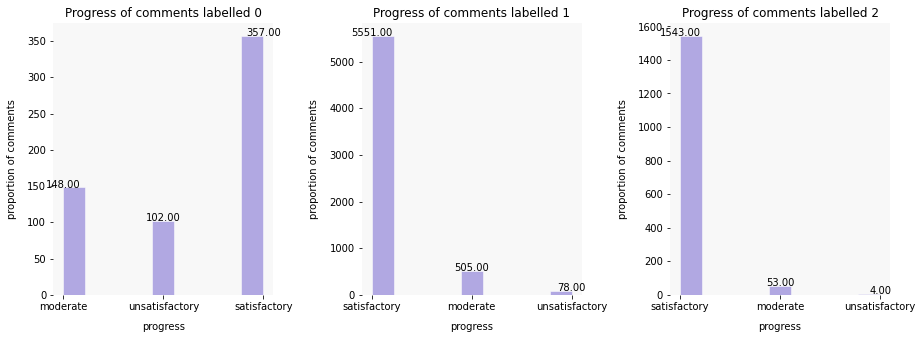

In [ ]:
f,axs = plt.subplots(1,3,figsize=(15, 5))
axs = axs.ravel()

labs = [] #list containing extract of the dataframe "annot"
                # labs[0] contains all values where label = 0
                # labs[1] contains all values where label = 1
                # labs[2] contains all values where label = 2

annot = dash_data1.copy()
idNA = np.where(annot.progress.isna() == False)
annot = annot.iloc[idNA].copy()

labs.append(annot["progress"].iloc[np.where(annot.BERTlabel_1 == 0)])
labs.append(annot["progress"].iloc[np.where(annot.BERTlabel_1 == 1)])
labs.append(annot["progress"].iloc[np.where(annot.BERTlabel_1 == 2)])

for i in range(3):
    #--- plot histogram
    weights = np.ones_like(labs[i])/float(len(labs[i])) #so that the histogram bars sum to 1
    """N, bins, patches = axs[i].hist(x = labs[i],bins = 9,weights=weights,
                                  align = 'mid',alpha = .5,edgecolor='white',linewidth=1)  """
    N, bins, patches = axs[i].hist(x = labs[i],bins = 9,
                                  align = 'mid',alpha = .5,edgecolor='white',linewidth=1)    
   
    #--- add color corresponding to progress
    for k in range(0,3):
        patches[k].set_facecolor('slateblue')
    for k in range(3,5):    
        patches[k].set_facecolor('slateblue')
    for k in range(5, len(patches)):
        patches[k].set_facecolor('slateblue')
    #--- add title and labels
    axs[i].set_title("Progress of comments labelled {}".format(i))
    axs[i].set_xlabel("progress",labelpad = 10)
    axs[i].set_ylabel("proportion of comments",labelpad = 10)
    #--- remove frames
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    #--- adjust subplots and background
    plt.subplots_adjust(wspace=.4)
    axs[i].patch.set_facecolor('grey')#background color
    axs[i].patch.set_alpha(0.05)#background color
    
    #--- add values above each bar 
    for j,v in enumerate (N[np.where(N!=0)]):
        axs[i].text(j, v, "%.2f" %v + "", ha="center",color = 'black', size = 10) 

plt.show()

## TO DO:

_______________________________________
1000 of each dataset and increase the size of one dataset (3000) and see if there is change.

- 6/9 experiments with subsets of this original dataset
- try to see the correlation between BERTlabel/groundtruth labels/progress
_______________________________________

In [ ]:
30: validation set: tune meta parameters
50: evaluation set


1 prediction mark with satisfactory level
1 prediction mark with label bert

In [ ]:
#---- check by hand the results
#a = dash_data.iloc[np.where(dash_data.BERTlabel2 != dash_data.BERTlabel)]
a = dash_data.iloc[np.where(dash_data.BERTlabel_1 == 2)]
b = dash_probs[np.where(dash_data.BERTlabel_1 == 2),:][0]
j=0
for i in range(10):
  print(a.comments.iloc[i])
  #print("BERTlabel: ", a.BERTlabel.iloc[i])
  print(b[j,:])
  j+=1
  print("")

https://github.com/huggingface/transformers/issues/6263


- send dataset for annotation (30/50 texts) to A and V **OK**
- check agreement between A and V if confusion a 3rd person annotates. 
- check annotation aggreeement between annotation (A,V) and progress on the dashboard. If I see there is an agreement, I can use the dahboard progress to annotate.
Or looking at the agreement among classes (satisfactory/moderate/unsatisfactory).
- data augmentation for text.\
https://neptune.ai/blog/data-augmentation-nlp \
https://arxiv.org/ftp/arxiv/papers/2107/2107.03158.pdf


- see if BERT is sensitive on the size of the data -> later 
- find a way to train BERT twice: first time on dataset found on internet and second time on our label dataset: https://github.com/amaiya/ktrain/blob/master/FAQ.md#how-do-i-resume-training-from-a-saved-checkpoint

- find a way to export the model BERT: (using PYTORCH) 

https://medium.com/analytics-vidhya/saving-and-loading-your-model-to-resume-training-in-pytorch-cb687352fa61

https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html



questions: 
est-ce que c'est pareil de fine tune sur un seul dataset qui contient nos data + les data d'internet ou est-ce que c'est mieux de fine tune en 2 fois: le dataset d'internet et puis notre propre dataset après ? 
Si oui, je ne sais pas comment faire du transfer learning pour le moment....

peut-être pour mieux comprendre regarder ce que fait la passe forward et backward du modèle.

# Drafts and unfinished codes

In [ ]:
l = [[ 4.2725e-02,  2.5470e-02,  3.8915e-01],
        [ 1.8440e-02, -7.4700e-02,  2.8701e-01],
        [ 7.0170e-02, -4.9360e-02,  2.7799e-01],
        [ 6.9618e-05, -8.2011e-02,  2.4084e-01],
        [ 9.1309e-02, -2.0337e-02,  2.6736e-01],
        [ 1.0598e-01,  2.8469e-02,  2.2281e-01],
        [ 1.3833e-02, -2.0461e-02,  1.8368e-01],
        [-1.5404e-02, -6.1609e-02,  2.6482e-01]] #logits (output of function forward)
logits = torch.Tensor(l); print("logits: ",logits); 
labels = torch.Tensor([ 1, -1,  1, -1,  0,  1, -1,  1]); print("labels: ", labels)
labels = torch.Tensor([ 2, 0,  2, 0,  1,  2, 0,  2]); print("labels: ", labels) 
# CLASS MUST SPAN TO 0 to 3

labels = labels.type(torch.LongTensor)
#LongTensor is synonymous with integer. 
#PyTorch won't accept a FloatTensor as categorical target, 
#so it's telling you to cast your tensor to LongTensor. 


m = nn.Softmax(dim=1)
output = m(logits) #apply softmax function to logits 
print("output: ",output)
loss = nn.CrossEntropyLoss()
print("loss CrossEntropyLoss:")
loss(output,labels)
#nn.BCEWithLogitsLoss(logits,labels)

#The input is expected to contain raw, unnormalized scores for each class.
#Thus, for TRAINING we don't use SOFTMAX 
# for GETTING PREDICTIONS from our model we use SOFTMAX

Common Error: Most likely there is mismatch between vocabulary size of tokenizer and bert model ( in bert config). Try setting vocab size of your tokenizer in bert config while initializing your model. https://github.com/huggingface/transformers/issues/5611


In [ ]:
def preprocessingForBert_long(data):
  """
  This function performs required preprocessing steps for pretrained BERT 
  for long texts (more than 510 tokens).
  ---> input: data (np.array): Array of texts to be processed.
  ---> ouput: 
  - input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
  - attention_masks (torch.Tensor): Tensor of indices specifying which
  tokens should be attended to by the model.

 If the input text exceeds 510 tokens (text without SEP and CLS tokens) then the 
 firsts 'nbFirst' and lasts 'nbLast' tokens are selected to match a length of 510 tokens. 
  """

  chunksize = 512 # define target chunksize
  nbFirst = 128 # number of tokens to take from the beginning of the text
  nbLast = 382  # number of tokens to take from the end of the text
                # nbFirst + nbLast = 510 (SEP and CLS tokens not present)

  # Create empty lists to store outputs
  input_ids = [] 
  attention_masks = [] 

  for comment in data:

    # create dictionary of 'input_ids' (=tokens) and 'attention_mask' and send it to pythorch
    encoded_c = tokenizer.encode_plus(comment, add_special_tokens=False,return_tensors='pt') 

    # if the number of tokens exceeds 510 then the firsts 'nbFirst'
    # and lasts 'nbLast' tokens are selected 
    if encoded_c["input_ids"][0].shape[0] > chunksize - 2: #-2 since SEP and CLS tokens are not present yet
      firstTok = encoded_c["input_ids"][0][:nbFirst]
      lastTok = encoded_c["input_ids"][0][-nbLast:]
      firstMask = encoded_c["attention_mask"][0][:nbFirst]
      lastMask = encoded_c["attention_mask"][0][-nbLast:]

      tokens = torch.cat((firstTok, lastTok))
      masks = torch.cat((firstMask, lastMask))
    else: # otherwise, let the tokens inchanged
      tokens =  encoded_c["input_ids"][0]
      masks = encoded_c["attention_mask"][0]

    # add SEP (token ID 101) and CLS (token ID 102)
    tokens = torch.cat([torch.tensor([101]), tokens, torch.tensor([102])])

    # add attention tokens to attention mask
    masks = torch.cat([torch.tensor([1]), masks, torch.tensor([1])])

    # get required padding length
    pad_len = chunksize  - len(tokens)

    # if padding length is more than 0 (ie the number of tokens < 512)
    # we must add padding so that each token has a size of 512
    if pad_len > 0: 
      tokens = torch.cat([tokens, torch.Tensor([0] * pad_len)]) #add 0s (which  is the token ID for [PAD])
      masks  = torch.cat([masks , torch.Tensor([0] * pad_len)]) #add 0s (which  is the token ID for [PAD])

    # Add the tokens of the encoded comment to the list.    
    input_ids.append(tokens.long()) ###

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(masks.int()) ###

  return input_ids,attention_masks

### data augmentation

In [ ]:
!pip install numpy requests nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nlpaug.augmenter.word as naw #works with version 3.0.2 of transformers

In [ ]:
text = 'The quick brown fox jumps over the lazy dog .'

In [ ]:
import os
os.environ["MODEL_DIR"] = '../model'

In [ ]:
#Insert word by contextual word embeddings (BERT, DistilBERT, RoBERTA or XLNet)
aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="insert")
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Original:
The quick brown fox jumps over the lazy dog .
Augmented Text:
['the three quick brown fox nearly jumps over the tiny lazy dog.']


In [ ]:
#Substitute word by contextual word embeddings (BERT, DistilBERT, RoBERTA or XLNet)

aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="substitute")
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
The quick brown fox jumps over the lazy dog .
Augmented Text:
['the baby brown fox jumps over a frightened dog.']


_____________


Documentation: for text data augmentation for sentiment analysis (we have to make sure that the augmentation does not change the main sentiment of the texts)

- https://computationalsocialnetworks.springeropen.com/track/pdf/10.1186/s40649-020-00080-x.pdf

- https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9543519&casa_token=EnD1Wh4tj90AAAAA:KcT6IIJj8O73B8ZIVc0LVk10aj_K2DgVUD0vgbi5Yi7TjxI9O9gH492UDcC0gDD_9BlyFNAuafiD (best paper)

- https://github.com/makcedward/nlpaug#augmenter (github repo)

=> **conclusion of these papers**: USE **BT (back-translation)** for data augmentation in the case of **small** and **imbalanced** datasets with **BERT**.



https://aclanthology.org/2021.emnlp-main.362.pdf -> new approach but maybe complicated


However, increasing the text with the BT is not enough as we want to reach at least 5*200 comments = 1000 comments.
We then use textual augmentation by Word embeddings which may not be the best solution but will increase the data further.  After several tests on our comments, I think that the method with Word embedding is still more efficient than the simple synonym replacement.

In [ ]:
# Install Transformers from source with the following command:  
# - We need to do this to use "back_translation" with "nlpaug", otherwise it does not work.
# - May need to restart runtime environment since "transformers==2.8.0" version has  
#   been previously loaded for BERT fine-tuning. 
#-------------------------------------------------
!pip install git+https://github.com/huggingface/transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-vo1_9ic5
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-vo1_9ic5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for transformers: filename=transformers-4.22.0.dev0-py3-none-any.whl size=4728143 sha256=09e57476cbb38c6f23f2e6c19b6e7cb7f494f2692bd59e1b7181c69589a83629
  Stored in directory: /tmp/pip-ephem-wheel-cache-8l2i3j2y/wheels/35/2e/a7/d819e3310040329f0f47e57c9e3e7a7338aa5e74c49acfe522
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 2.8.0
    Uninstalling transformers-2.8.0:
      Successfully uninstalled transformers-2.8.0


In [ ]:
#Import nlpaug library
#-------------------------------------------------
import nlpaug.augmenter.word as naw

# Dowload the back_translation model.
#-------------------------------------------------
#---  Use english_german translation (default model) 
back_translation_aug_de = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-en-de', #english-deutch 
    to_model_name='facebook/wmt19-de-en'    #deutch-english 
)
#--- Use english-french translation 
back_translation_aug_fr = naw.BackTranslationAug(
    from_model_name='Helsinki-NLP/opus-mt-en-fr', #english-french 
    to_model_name='Helsinki-NLP/opus-mt-fr-en'    #french-english 
)

#--- Use english-chinese translation 
back_translation_aug_zh = naw.BackTranslationAug(
    from_model_name='Helsinki-NLP/opus-mt-en-zh', #english-chinese 
    to_model_name='Helsinki-NLP/opus-mt-zh-en'    #chinese-english 
)

# documentation on naw.BackTranslationAug: 
# https://nlpaug.readthedocs.io/en/latest/augmenter/word/back_translation.html


# Dowload the contextual word embeddings model.
# Substitute word by contextual word embeddings (here with BERT)
#-------------------------------------------------
context_embedding_aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="substitute")

Downloading:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/312M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/312M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/805k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.62M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/805k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/807k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.62M [00:00<?, ?B/s]

In [ ]:
def augmentText(data2,method_aug):
  """
  this function augments the text data with the method provided
  ---> input:
  - data2 (dataFrame): dataframe containing 2 columns {"commments", "label"}
  - method_aug: method for text augmentation
  ---> ouput:
  - aug_data2 (dataFrame): dataframe with the same dimensions as data2 containing
  the modified "comments" with the augmented method and the corresponding label
  """

  aug = [] #list of the augmented comments in the same order as the comments in data2

  for i in range(len(data2)):
    text = data2.comments.iloc[i]
    aug.append(method_aug.augment(text))  

  aug_data2 = pd.DataFrame(aug)
  aug_data2.rename(columns={0:"comments"},inplace=True)
  aug_data2.index = data2.index
  aug_data2["label"] = data2["label"].copy()
  return aug_data2 

In [ ]:
NUM_COPIES = 5
aug_dataS = [] #list containing different augmentations with 


for i in range(NUM_COPIES):
  aug_dataS.append(augmentBT(data2))

In [ ]:
 pd.concat(aug_dataS, axis=0)

,comments,label
7474,Were investigating DB design MySQL Django Acco...,1
6542,Draft of functional spec sent as per deliverab...,1
2832,November via Skype Discussed shared dataset E...,1
6464,Met on group call,1
1384,Finished the AI!!! Tweaking the bugs wrt the ...,1
...,...,...
2664,So has progressed well and now has tslearn wor...,2
178,Implemented Linear Regression with small datas...,1
8745,"math model and DRL model is general done, next...",0
9829,"Met discussed project implementation, needs to...",0


In [ ]:
print("--- Original text:")
print(text = 'The quick brown fox jumped over the lazy dog')
print("--- BT english-deutch:")
print(back_translation_aug_de.augment(text))
print("--- BT english-french:")
print(back_translation_aug_fr.augment(text))
print("--- BT english-chinese:")
print(back_translation_aug_zh.augment(text))
print("--- Context word embedding (BERT):")
print(context_embedding_aug.augment(text))

original text:
BT english-deutch:
['The speedy brown fox leapt over the lazy dog']
BT english-french:
['The fast brown fox jumped on the lazy dog']
BT english-chinese:
['Fast brown fox skips a lazy dog, skips a lazy dog.']
context word embedding (BERT):
['her same brown fox jumped over another lazy dog']


il y a un pb avec la librarie predator: il y a une méthode qui a besoin d'être upgradée donc je ne peux pas l'utiliser...

Synonym Augmenter \
Substitute word by WordNet's synonym \

Je n'ai pas très envie d'utiliser les embeddings comme synonyme car: "bad" "good" pourraient avoir des embeddings similaires (car ils sont utilisés dans les mêmes cas de figure) alors que le sentiment est totalement différent. Mais avec plusieurs exemples, on dirait que le synonyme marche moins bien que word embedding